# Introduction
In this assignment, we will be using a modified version of the “CRCHistoPhenotypes” dataset for this task.  The data set to use in this assignment has been specifically prepared .  The dataset consists of 27x27 RGB images of colon cellsfrom 99 different patients. 

I have developed a ML model using multiple ML techniques to Classify images according to whether given cell image represents a cancerous cellsor not (isCancerous) from the given dataset.


# Objective

- Classify images according to whether given cell image represents a cancerous cellsor not (isCancerous) from the given dataset.
- come up with an approach where each  element  of  the  system  is justified using  data  analysis,  performance  analysis and/or knowledge from relevant literature.
- Train different ML models, determining how the data split will be split and evaluate which one is the most appropriate for this task
- Setup an evaluation framework, including selecting appropriate performance measures
- Analyse the model and the results from my model using appropriate techniques and establish how adequate my model is to perform the task in real world and discuss limitation if there are any 
- Predict the result for the test set.

# Dataset

In this Assignment we will be using modified version of the “CRCHistoPhenotypes” dataset 


The columns of the dataset are:

1. InstanceID: Unqiue number to represent cell ID
2. PatientID: Unqiue number to represent patient ID
3. ImageName: Name of saved image  
4. CellTypeName: Name of HISTOPATHOLOGY cells
5. cellType: Which class the cell belongs to ({'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3})
6. isCancerous: if the given cell is cancerous or not

# 1.1 Load Dataset

In [3]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
from tensorflow import keras
from tqdm import tqdm_notebook,trange
import cv2
# from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

import staintools
import gc

In [7]:
#load dataset and create a dataframe with adjacent imageNames
path = "./Image_classification_data/" #adapt this path, when running locally
train_path = path + 'patch_images/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.png'))}) # load the filenames
print(df)

df['InstanceID'] = df.path.map(lambda x: int(x.split('/')[3].split(".")[0]))
print(df.dtypes)
labels = pd.read_csv(path+"data_labels_mainData.csv") # read the provided labels
print(labels.dtypes)

df = pd.merge(df, labels, on='InstanceID', how='right')


df.head(3)

                                                    path
0      ./Image_classification_data/patch_images/3975.png
1      ./Image_classification_data/patch_images/17843...
2      ./Image_classification_data/patch_images/21329...
3      ./Image_classification_data/patch_images/8820.png
4      ./Image_classification_data/patch_images/14392...
5      ./Image_classification_data/patch_images/9280.png
6       ./Image_classification_data/patch_images/348.png
7      ./Image_classification_data/patch_images/15932...
8      ./Image_classification_data/patch_images/12085...
9      ./Image_classification_data/patch_images/1804.png
10     ./Image_classification_data/patch_images/22146...
11     ./Image_classification_data/patch_images/10692...
12     ./Image_classification_data/patch_images/20751...
13     ./Image_classification_data/patch_images/11598...
14     ./Image_classification_data/patch_images/4968.png
15     ./Image_classification_data/patch_images/10686...
16     ./Image_classification_d

,path,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,./Image_classification_data/patch_images/3975.png,3975,42,3975.png,others,3,0
1,./Image_classification_data/patch_images/8820.png,8820,17,8820.png,epithelial,2,1
2,./Image_classification_data/patch_images/9280.png,9280,21,9280.png,epithelial,2,1


In [8]:
# Check is null values are present
df.isnull().values.any()

False

In [9]:
print(df.shape[0])  # 



9896


In [10]:
# Check if duplicate cells are found
print(df['path'].duplicated().any())
print(df['InstanceID'].duplicated().any())

False
False


In [11]:
# Drop columns cellTypeName and cellType as they aren't used to classify if cells are cancerous or not.
df = df.drop('cellTypeName', 1)
df = df.drop('cellType', 1)

In [12]:
df.head(3)

,path,InstanceID,patientID,ImageName,isCancerous
0,./Image_classification_data/patch_images/3975.png,3975,42,3975.png,0
1,./Image_classification_data/patch_images/8820.png,8820,17,8820.png,1
2,./Image_classification_data/patch_images/9280.png,9280,21,9280.png,1


# 1.2 Concating extraData for larger dataset

We will not concat data_labels_extraData with data_labels_mainData, allowing the models to be trained on a bigger dataset resulting in better results and possible reducing common issues like overfitting and underfitting

In [13]:

# concat data_labels_extraData to have a bigger dataset resulting in better results.
df_extra = pd.DataFrame({'path': glob(os.path.join(train_path,'*.png'))}) # load the filenames
print(df_extra)

df_extra['InstanceID'] = df_extra.path.map(lambda y: int(y.split('/')[3].split(".")[0]))
print(df_extra.dtypes)
labels_extra = pd.read_csv(path+"data_labels_extraData.csv") # read the provided labels
print(labels_extra.dtypes)

df_extra = pd.merge(df_extra, labels_extra, on='InstanceID', how='right')
df_extra.head(5)



                                                    path
0      ./Image_classification_data/patch_images/3975.png
1      ./Image_classification_data/patch_images/17843...
2      ./Image_classification_data/patch_images/21329...
3      ./Image_classification_data/patch_images/8820.png
4      ./Image_classification_data/patch_images/14392...
5      ./Image_classification_data/patch_images/9280.png
6       ./Image_classification_data/patch_images/348.png
7      ./Image_classification_data/patch_images/15932...
8      ./Image_classification_data/patch_images/12085...
9      ./Image_classification_data/patch_images/1804.png
10     ./Image_classification_data/patch_images/22146...
11     ./Image_classification_data/patch_images/10692...
12     ./Image_classification_data/patch_images/20751...
13     ./Image_classification_data/patch_images/11598...
14     ./Image_classification_data/patch_images/4968.png
15     ./Image_classification_data/patch_images/10686...
16     ./Image_classification_d

,path,InstanceID,patientID,ImageName,isCancerous
0,./Image_classification_data/patch_images/17843...,17843,82,17843.png,0
1,./Image_classification_data/patch_images/21329...,21329,92,21329.png,0
2,./Image_classification_data/patch_images/14392...,14392,66,14392.png,1
3,./Image_classification_data/patch_images/15932...,15932,64,15932.png,0
4,./Image_classification_data/patch_images/1804.png,1804,77,1804.png,0


In [14]:
print(df_extra.shape[0]) 

10384


In [15]:
df_extra.isnull().values.any()

False

In [16]:
print(df_extra['path'].duplicated().any())
print(df_extra['InstanceID'].duplicated().any())

False
False


In [17]:
df_extra.head(10)

,path,InstanceID,patientID,ImageName,isCancerous
0,./Image_classification_data/patch_images/17843...,17843,82,17843.png,0
1,./Image_classification_data/patch_images/21329...,21329,92,21329.png,0
2,./Image_classification_data/patch_images/14392...,14392,66,14392.png,1
3,./Image_classification_data/patch_images/15932...,15932,64,15932.png,0
4,./Image_classification_data/patch_images/1804.png,1804,77,1804.png,0
5,./Image_classification_data/patch_images/22146...,22146,83,22146.png,0
6,./Image_classification_data/patch_images/10692...,10692,79,10692.png,0
7,./Image_classification_data/patch_images/20751...,20751,84,20751.png,0
8,./Image_classification_data/patch_images/11598...,11598,65,11598.png,1
9,./Image_classification_data/patch_images/10686...,10686,79,10686.png,0


In [18]:
# Append to orignal dataset
df = df.append(df_extra,ignore_index=True)

# 2. Summarise Data

In [19]:
df.head(3)

,path,InstanceID,patientID,ImageName,isCancerous
0,./Image_classification_data/patch_images/3975.png,3975,42,3975.png,0
1,./Image_classification_data/patch_images/8820.png,8820,17,8820.png,1
2,./Image_classification_data/patch_images/9280.png,9280,21,9280.png,1


In [20]:
# Check shape of the new combined dataset
print(df.shape[0]) 

20280


In [21]:
df.isnull().values.any()

False

In [22]:
print(df['path'].duplicated().any())
print(df['InstanceID'].duplicated().any())
print(df['ImageName'].duplicated().any())

False
False
False


In [23]:
df.iloc[-1]

path           ./Image_classification_data/patch_images/17682...
InstanceID                                                 17682
patientID                                                     62
ImageName                                              17682.png
isCancerous                                                    0
Name: 20279, dtype: object

In [24]:
df.count()

path           20280
InstanceID     20280
patientID      20280
ImageName      20280
isCancerous    20280
dtype: int64

## 3. Exploratory Data Analysis (EDA)
#### The purpose of this EDA is to:

- Take a look at the images and how pixelated these are
- Understand the distribution of the two classes (no cancer cells / cancer cells)
- Have a look at some image features (RGB channel distributions, mean brightness)

The next step would be to create a user defined function that loads in the images. This would be done using tfdm library. It provides a great user interface by displaying a progress bar while the images are loaded making it more user friendly.

In [19]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a list for the images (N, 27x27px, 3 channels, values 0 - 255)

    X = []
    c = 0
    #convert the labels to a numpy array too
    y = np.squeeze(df.as_matrix(columns=['isCancerous']))[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        if row['path']:
            X.append(cv2.imread(row['path']))
            c+= 1

    print(c)
    return X,y

In [20]:
N=df.shape[0]
X,y = load_data(N=N,df=df) 

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/20280 [00:00<?, ?it/s]

20280


In [21]:
X1 = np.array(X)

### 3.1 Let's plot some example images with their assigned label (0 - no cancer cells, 1 - cancer cells):

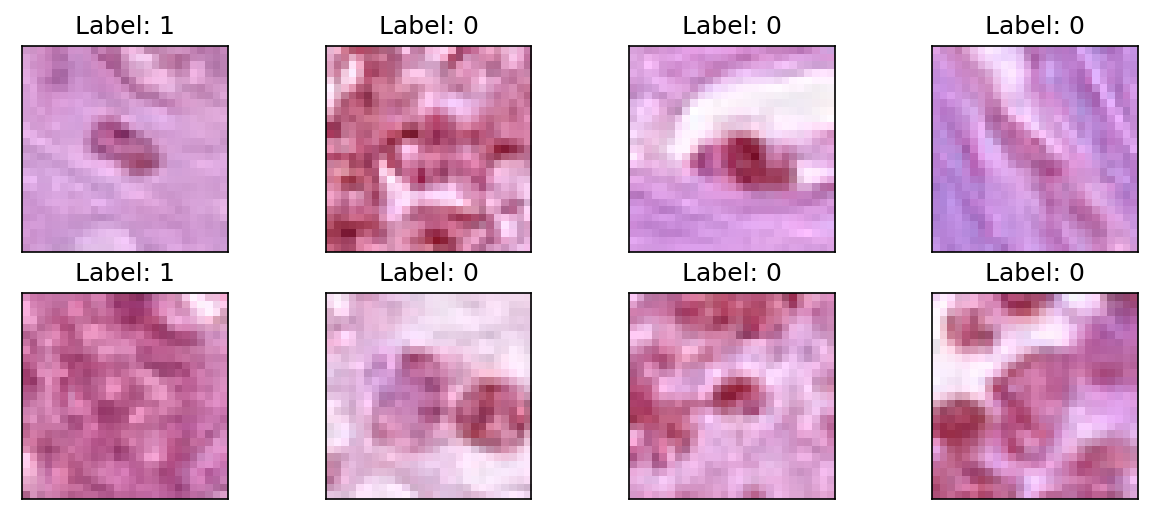

In [144]:
import random
fig = plt.figure(figsize=(10, 4), dpi=150)

num1 = random.randint(0, 9)
count = 0

 
np.random.seed(100)

for plotNr,idx in enumerate(np.random.randint(0,N,8)):


    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

        
        
        

## 3.2 Data distribution
We'll start by looking at how often the classes are represented.

Text(0, 0.5, '# of samples')

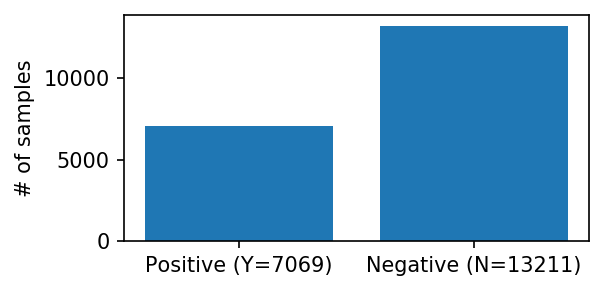

In [217]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (Y={})".format((y==1).sum())]);
plt.ylabel("# of samples")

### What do we observe?
We observe that we have a class imbalance, i.e. 65/35 split of negative to postive samples in the data.
This is important because it means atrivial classifier, that just labels every sample as negative, would achieve an accuracy of 65%. Possible countermeasures to avoid a bias in the classifier and improve stability during training are, e.g., over- and undersampling.


We'll now split the data into positive and negative samples to get an idea what makes the classes unique. Such an analysis can often provide insight into possible feature engineering possibilities or which data transformations may be useful.

In [23]:
positive_samples = X1[y == 1]
negative_samples = X1[y == 0]

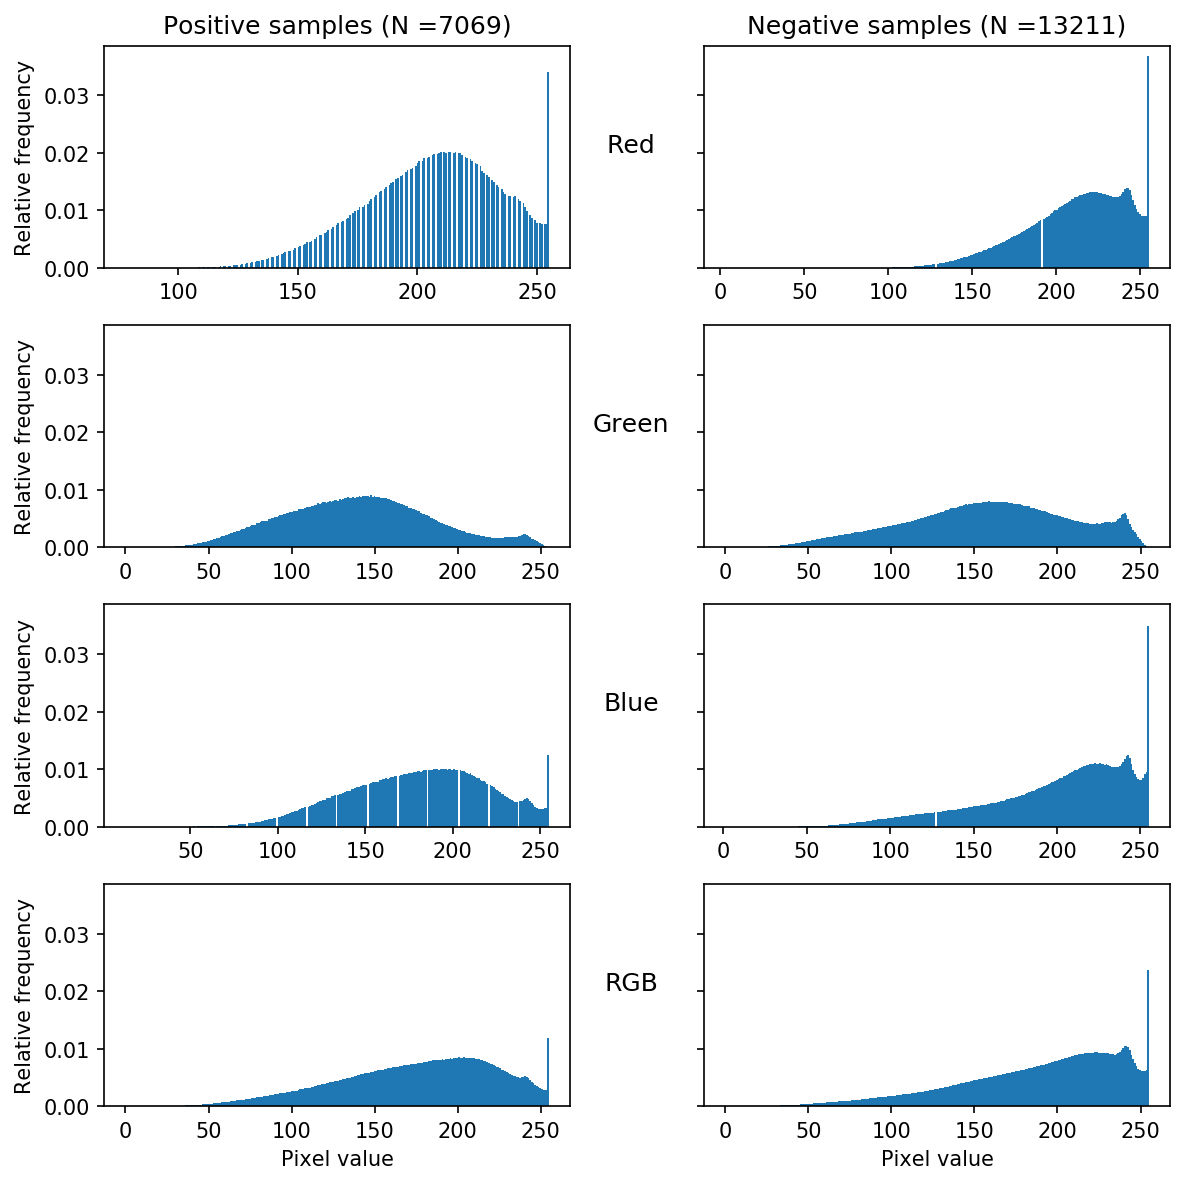

In [220]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

### Observations:
- Negative samples have a higher/brighter pixel values especially in the blue color channel
- Both negative and postive samples have brighter red color compared to more darker tone of green
- The positive samples have a darker green channel than red and blue and this is also true for the negative samples. However, very dark pixels are for both sample sets mostly only present in the green channel.
- Furthermore, note the relatively high frequency of the pixel value 255. Looking at the data above we can see, that these can likely be attributed to the bright white image regions present in some images. They seem to be present in both positive and negative samples similarly frequently.

### 3.3 Distribution of mean image brightness, i.e. mean image pixel values. 
- Note, previously we were averaging over all pixel values in the positive and negative samples. Now, we will take the mean of each individual image and look at that distribution.

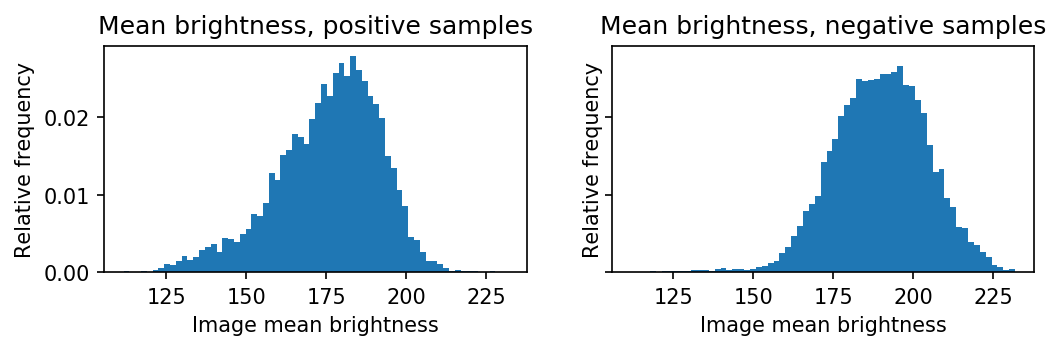

In [221]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

### Observations:
- We observe some obvious differences between postive and negatiive samples. The distribution of both postive and negative samples follow a normal distribution around a brightness of 185-190.
- Another key difference is that negative samples are much more brighter than the postive samples. We can observe this because of the range of normal distribution curve and the difference in peaks of the curve.

### EDA Conclusion:
- There are some easily spotted differences in the distributions of pixel values and mean image brightness between positive and negative samples. This is good, because whatever model we will use can likely use this.
- Some of the images seem to contain very bright regions, which are likely artifacts of the recording process. We might have to find a way to deal with them. They are almost equally distributed between positive and negative samples and, hence, probably not easily usable as a feature.

Because of the following reasons we will perform **Stain Normalization**.

Stain normalization is an important processing task for computer-aided diagnosis (CAD) systems in modern digital pathology expecially when dealing with Histopathologic Cells. This task reduces the color and intensity variations present in stained images from different laboratories.

Color variation is a problem in histopathology based on light microscopy due to multiple reasons which can range from ussing different scanners, variable chemical from different manufactures of stains. The coloring can also depend on different staining procedures, timing, concentration etc. These factors cause color variation in histopathology, Hence the use of Stain Normalization is important to reduce the color variation between all samples.
(1) (PDF) A Non-Linear Mapping Approach to Stain Normalisation in Digital Histopathology Images using Image-Speciﬁc Colour Deconvolution. Available from: https://www.researchgate.net/publication/260288815_A_Non-Linear_Mapping_Approach_to_Stain_Normalisation_in_Digital_Histopathology_Images_using_Image-Specific_Colour_Deconvolution [accessed May 19 2021].

Report Example: 

Stain normalization has increased accuracy, precision, recall, and f-score values by ap-proximately 10%, as shown in Table7.These results indicate that the stain normaliza-tion step is an effective pre-processing part which can mitigate high staining intensityvariance between histology samples 

(1) (PDF) Deep Learning Model for Cell Nuclei Segmentation and Lymphocyte Identification in Whole Slide Histology Images. Available from: https://www.researchgate.net/publication/348411519_Deep_Learning_Model_for_Cell_Nuclei_Segmentation_and_Lymphocyte_Identification_in_Whole_Slide_Histology_Images [accessed May 19 2021].

# 4. Pre processing Images

As we can see, we have chosen image '1.png' as our target image and we will transform the rest of the images based on that

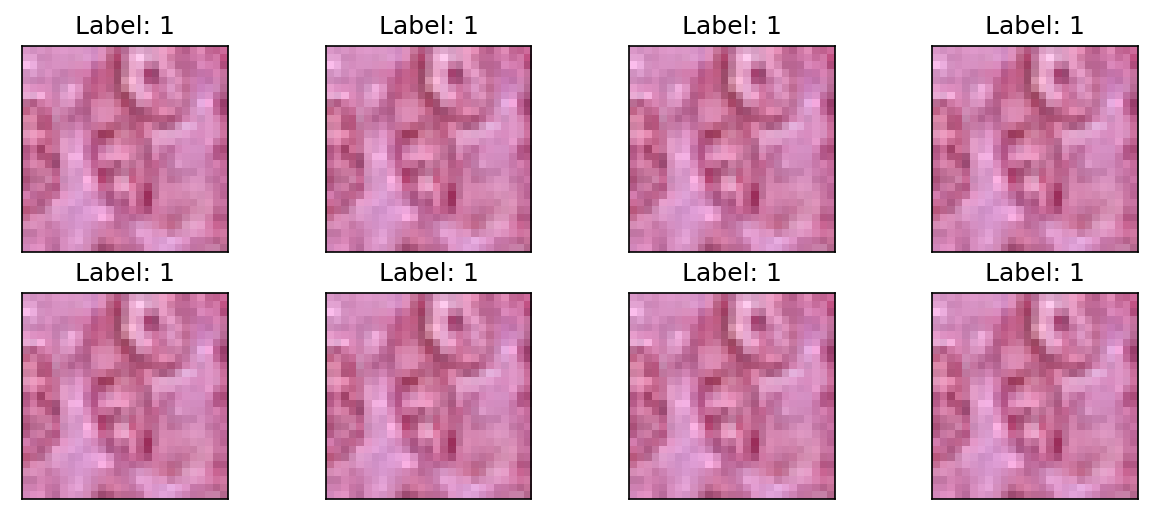

In [65]:
# 1.png image
fig = plt.figure(figsize=(10, 4), dpi=150)


for plotNr,idx in enumerate(np.random.randint(0,N,8)):


    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[1]) #plot image
    ax.set_title('Label: ' + str(y[1])) #show the label corresponding to the image

Lets see how a random image '93.png' is different from our target image

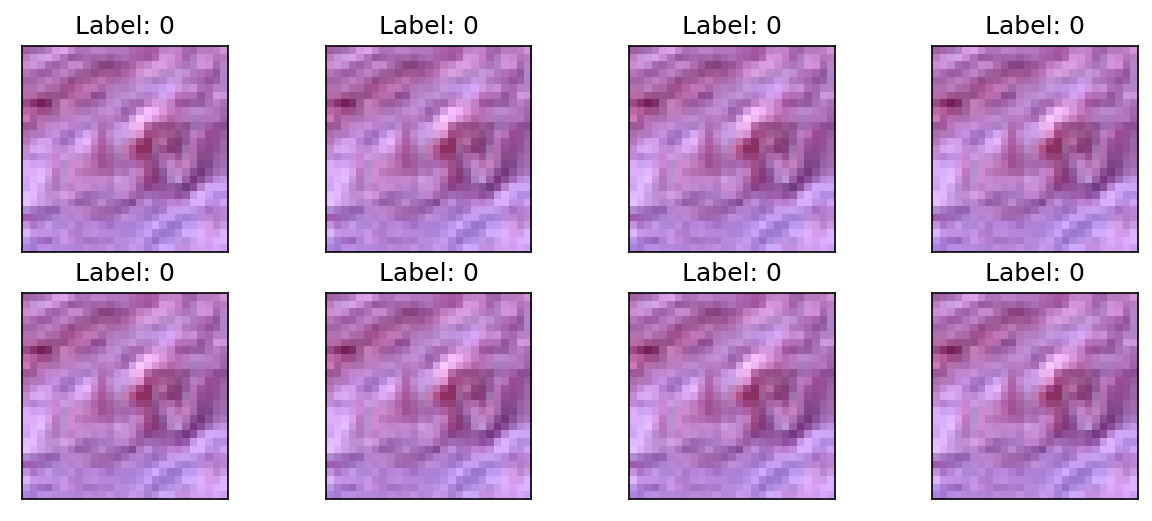

In [229]:
fig = plt.figure(figsize=(10, 4), dpi=150)

num1 = random.randint(0, 9)
count = 0

 #we can use the seed to get a different set of random images
np.random.seed(100)
# while count != 10:
# for i in range(0,8)
for plotNr,idx in enumerate(np.random.randint(0,N,8)):


    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[93]) #plot image
    ax.set_title('Label: ' + str(y[93]))

### Observation:

A clear difference is seen between two images and their stains, which shows the need to stain normalise all the images.

In [26]:
i = './Image_classification_data/transformed_images'
os.mkdir(str(i))


In [107]:
# Target image for Stain Normalization
target = staintools.read_image("./Image_classification_data/patch_images/1.png")




In [110]:
# Stain normalizating all the images and saving them to a new directory " transformed_images"
count = 0
for l in range(1753,df.shape[0]):

    path = df['path'][l]

    if str(path) != "./Image_classification_data/patch_images/1.png":
        print(str(path))
        to_transform = staintools.read_image(path)
        target = staintools.LuminosityStandardizer.standardize(target)
        to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
        normalizer = staintools.StainNormalizer(method='vahadane')
        normalizer.fit(target)
        transformed = normalizer.transform(to_transform)
        new_path = './Image_classification_data/transformed_images/'+ str(df['ImageName'][l])
        cv2.imwrite(str(new_path), transformed.astype(np.uint8))
        count += 1

    

./Image_classification_data/patch_images/18961.png
./Image_classification_data/patch_images/11945.png
./Image_classification_data/patch_images/9091.png
./Image_classification_data/patch_images/22357.png
./Image_classification_data/patch_images/20568.png
./Image_classification_data/patch_images/171.png
./Image_classification_data/patch_images/9907.png
./Image_classification_data/patch_images/22419.png
./Image_classification_data/patch_images/1383.png
./Image_classification_data/patch_images/617.png
./Image_classification_data/patch_images/16964.png
./Image_classification_data/patch_images/21110.png
./Image_classification_data/patch_images/3594.png
./Image_classification_data/patch_images/18949.png
./Image_classification_data/patch_images/16970.png
./Image_classification_data/patch_images/21104.png
./Image_classification_data/patch_images/3580.png
./Image_classification_data/patch_images/13808.png
./Image_classification_data/patch_images/603.png
./Image_classification_data/patch_images/1

We can see how the stain has changed of a transformed image

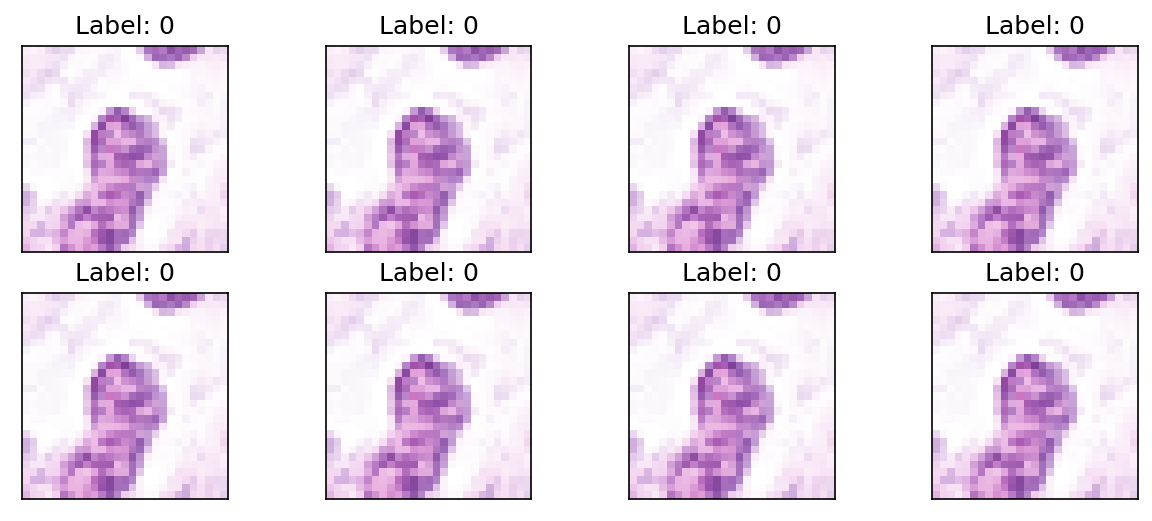

In [47]:
fig = plt.figure(figsize=(10, 4), dpi=150)


count = 0


np.random.seed(100)

for plotNr,idx in enumerate(np.random.randint(0,N,8)):


    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(transformed) #plot image
    ax.set_title('Label: ' + str(y[93]))

In [112]:
new_path = './Image_classification_data/transformed_images/1.png'
cv2.imwrite(str(new_path), target.astype(np.uint8))

True

## Creating dataframe with transformed images

Lets create a new dataframe of the transformed images

In [23]:
path = "./Image_classification_data/" #adapt this path, when running locally
train_path = path + 'transformed_images/'

df_transformed = pd.DataFrame({'path': glob(os.path.join(train_path,'*.png'))}) # load the filenames
print(df_transformed)

df_transformed['InstanceID'] = df_transformed.path.map(lambda x: int(x.split('/')[3].split(".")[0]))
print(df_transformed.dtypes)
labels = pd.read_csv(path+"data_labels_mainData.csv") # read the provided labels
print(labels.dtypes)

df_transformed = pd.merge(df_transformed, labels, on='InstanceID', how='right')


df_transformed.head(3)



                                                    path
0      ./Image_classification_data/transformed_images...
1      ./Image_classification_data/transformed_images...
2      ./Image_classification_data/transformed_images...
3      ./Image_classification_data/transformed_images...
4      ./Image_classification_data/transformed_images...
5      ./Image_classification_data/transformed_images...
6      ./Image_classification_data/transformed_images...
7      ./Image_classification_data/transformed_images...
8      ./Image_classification_data/transformed_images...
9      ./Image_classification_data/transformed_images...
10     ./Image_classification_data/transformed_images...
11     ./Image_classification_data/transformed_images...
12     ./Image_classification_data/transformed_images...
13     ./Image_classification_data/transformed_images...
14     ./Image_classification_data/transformed_images...
15     ./Image_classification_data/transformed_images...
16     ./Image_classification_d

,path,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,./Image_classification_data/transformed_images...,3975,42,3975.png,others,3,0
1,./Image_classification_data/transformed_images...,8820,17,8820.png,epithelial,2,1
2,./Image_classification_data/transformed_images...,9280,21,9280.png,epithelial,2,1


In [24]:
print(df_transformed['path'].duplicated().any())
print(df_transformed['InstanceID'].duplicated().any())

False
False


In [25]:
df_transformed = df_transformed.drop('cellTypeName', 1)
df_transformed = df_transformed.drop('cellType', 1)

In [26]:
df_transformed.head(10)

,path,InstanceID,patientID,ImageName,isCancerous
0,./Image_classification_data/transformed_images...,3975,42,3975.png,0
1,./Image_classification_data/transformed_images...,8820,17,8820.png,1
2,./Image_classification_data/transformed_images...,9280,21,9280.png,1
3,./Image_classification_data/transformed_images...,348,20,348.png,0
4,./Image_classification_data/transformed_images...,12085,55,12085.png,0
5,./Image_classification_data/transformed_images...,4968,8,4968.png,1
6,./Image_classification_data/transformed_images...,9294,21,9294.png,1
7,./Image_classification_data/transformed_images...,12091,55,12091.png,0
8,./Image_classification_data/transformed_images...,3961,42,3961.png,0
9,./Image_classification_data/transformed_images...,16591,24,16591.png,0


In [27]:
# Load the extra dataset
df_extra_transformed = pd.DataFrame({'path': glob(os.path.join(train_path,'*.png'))}) # load the filenames
print(df_extra_transformed)

df_extra_transformed['InstanceID'] = df_extra_transformed.path.map(lambda y: int(y.split('/')[3].split(".")[0]))
print(df_extra_transformed.dtypes)
labels_extra = pd.read_csv(path+"data_labels_extraData.csv") # read the provided labels
print(labels_extra.dtypes)

df_extra_transformed = pd.merge(df_extra_transformed, labels_extra, on='InstanceID', how='right')
df_extra_transformed.head(5)


                                                    path
0      ./Image_classification_data/transformed_images...
1      ./Image_classification_data/transformed_images...
2      ./Image_classification_data/transformed_images...
3      ./Image_classification_data/transformed_images...
4      ./Image_classification_data/transformed_images...
5      ./Image_classification_data/transformed_images...
6      ./Image_classification_data/transformed_images...
7      ./Image_classification_data/transformed_images...
8      ./Image_classification_data/transformed_images...
9      ./Image_classification_data/transformed_images...
10     ./Image_classification_data/transformed_images...
11     ./Image_classification_data/transformed_images...
12     ./Image_classification_data/transformed_images...
13     ./Image_classification_data/transformed_images...
14     ./Image_classification_data/transformed_images...
15     ./Image_classification_data/transformed_images...
16     ./Image_classification_d

,path,InstanceID,patientID,ImageName,isCancerous
0,./Image_classification_data/transformed_images...,17843,82,17843.png,0
1,./Image_classification_data/transformed_images...,21329,92,21329.png,0
2,./Image_classification_data/transformed_images...,14392,66,14392.png,1
3,./Image_classification_data/transformed_images...,15932,64,15932.png,0
4,./Image_classification_data/transformed_images...,1804,77,1804.png,0


Let us now combine the extraData and mainData of the transformed images resulting in a bigger dataset to train our models

In [28]:
df_transformed = df_transformed.append(df_extra_transformed,ignore_index=True)

In [29]:
df_transformed.count()

path           20280
InstanceID     20280
patientID      20280
ImageName      20280
isCancerous    20280
dtype: int64

# 5. Model Development


A typical ML model development process consists of 4 steps, which are as following:

1. **Determine your goals / Set up performance (evaluation) metric**: Performance metric and target value. Problem dependent.

2. **Setup the experiment**: Setup the test/validation data, visualisers and debuggers needed to determine bottlenecks in performance (overfitting/under-fitting, feature importance).

3. **Default Baseline Model**: Identify the components of end-to-end pipeline including - Baseline Models, cost functions, optimisation.

4. **Make incremental changes**: Repeatedly make incremental changes such as gathering new data, adjusting hyper-parameters, or changing algorithms, based on specific findings from your instrumentation.

## 5.1 Performance (evaluation) metric
There are many performance metrics that apply to this problem such as `precision`, `f1_score`, etc. 

The insights gained in the EDA becomes vital in determining the performance metric. For this problem, I have decided to use **Area under the ROC Curve (AUC)** as my perfomance metric.

ROC curve is the relationship between True Positive Rate (TPR) and False Positive Rate (FPR) given by different threshold.
(https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

True Postitive Rate: Among all the Positives, what percentage of them is correctly classified as Positive
False Postitive Rate: Among all the Negatives, what percentage of them is falsely classified as Positive

AUC is the area under the ROC curve. It is known to be one of the best measuesrs to measure how well a model can distiinguish between two classes. As the model gets better, the AUC also gets better.
AUC score ranges from 0.5 to 1. 1 is the ideal case where TPR is 1 and FPR is 0 signifying classification of all postives and negatives.
(https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

AUC can handle class imbalance very well or in other words is sensitive to imbalance or uneven classes. When there is a minority class, we define that as the positive class and that has a strong impact on AUC value.
Accuracy is not sensitive like AUC which would mean that accuracy can be very high even when minority class is not predicted well.
AUC is sensitive to class imbalance in the sense that when there is a minority class, we typically define this as the positive class and it will have a strong impact on the AUC value. This is very much desirable behaviour. Accuracy is for example not sensitive in that way. It can be very high even if the minority class is not well predicted at all.
**Thus, AUC ROC is an optimal performance metric considering we have an imbalance in our target classes.**



## 5.2 Setup the experiment 

Next **what data should we use to evaluate the performance?**


We can generate "simulated" unseen data in several methods
1. CNN ( Convolutional neural networks )
2. RNN ( Recurrent neural networks )
3. ANN ( Artificial neural networks )


We will implement **CNN** technique to build our Machine Learning models and analyse their performance.

## 5.2.1 CNN

In CNN we divide the data into 3 subsets:
1. Training Data: The subset we will use to build our model
2. Validation Data: The subset we will use to tune the Machine Learning's models hyper-parameters and do model selection.
3. Test Data: The subset we will use to evaluate the performance of the developed model.

### Let's divide the data into 60/20/20

#### Why 60/20/20?

We decide the proportions according to the size and type of the data avaiable to use. A general rule is that if the dataset is between 100 to 10,00,000 then we split it in the ration 60:20:20, where 60% percent is training set, 20% is validation set and 20% is test set. If the size of the data is greater than 1 million we can split it in the ration of 98:1:1.
(https://www.coursera.org/lecture/deep-neural-network/train-dev-test-sets-cxG1s)
#### In our case, if a 60/20/20 ratio isn't followed then the following problems might arise:
- If the validation dataset isn't randomised or is too small, then it will underperform for even good machine learning models, only reflecting the trends that are present in the small validation set. 
- If we use all our data as a training set then there is a chance the model will memorize the trends in the training data, thus causing the model to "overfit". 
- If the test dataset isn't randomised or is too small, then we might not be able to truly analyse our model's prediction capability. 

In [25]:
df['isCancerous'] = df['isCancerous'].apply(str)

In [26]:
# Spliting the dataset which contain orignal images (i.e. images without Stain Normalization)

with pd.option_context('mode.chained_assignment', None):
    train_data_, test_data = train_test_split(df, test_size=0.2, 
                                              shuffle=True,random_state=0)
    
with pd.option_context('mode.chained_assignment', None):
    train_data, val_data = train_test_split(train_data_, test_size=0.25, 
                                            shuffle=True,random_state=0)
    
print(train_data.shape[0], val_data.shape[0], test_data.shape[0])

train_data_feature = train_data.copy()
test_data_feature = test_data.copy()
val_data_feature = val_data.copy()

12168 4056 4056


In [32]:
train_X = train_data.drop(['isCancerous'], axis=1)
train_y = train_data[['isCancerous']].to_numpy()
val_X = val_data.drop(['isCancerous'], axis=1)
val_y = val_data[['isCancerous']].to_numpy()
test_X = test_data.drop(['isCancerous'], axis=1)
test_y = test_data[['isCancerous']].to_numpy()

In [33]:
 df_transformed['isCancerous'] = df_transformed['isCancerous'].apply(str)

In [34]:
# Spliting the dataset which contain Stain Normalized images (i.e. images with Stain Normalization)
with pd.option_context('mode.chained_assignment', None):
    train_data_trans, test_data_transformed = train_test_split(df_transformed, test_size=0.2, 
                                              shuffle=True,random_state=0)
    
with pd.option_context('mode.chained_assignment', None):
    train_data_transformed, val_data_transformed = train_test_split(train_data_trans, test_size=0.25, 
                                            shuffle=True,random_state=0)
    
print(train_data_transformed.shape[0], test_data_transformed.shape[0], val_data_transformed.shape[0])

train_data_feature_transformed = train_data_transformed.copy()
test_data_feature_transformed = test_data_transformed.copy()
val_data_feature_transformed = val_data_transformed.copy()


12168 4056 4056


In [35]:
train_X_transformed = train_data_transformed.drop(['isCancerous'], axis=1)
train_y_transformed = train_data_transformed[['isCancerous']].to_numpy()
val_X_transformed = val_data_transformed.drop(['isCancerous'], axis=1)
val_y_transformed = val_data_transformed[['isCancerous']].to_numpy()
test_X_transformed = test_data_transformed.drop(['isCancerous'], axis=1)
test_y_transformed = test_data_transformed[['isCancerous']].to_numpy()

# 5.3 Defining Machine Learning Models 

- **CNN** : A CNN is a class of deep neural networks which is most commonly used to analyze viual imagery. CNN uses a special technique called Convolution instead of matriix multiiplications. CNN are composed of multiple layers of artifical neurons. When we input an image in a ConvNet, each layer generates several activation functions that are passed on to the next layer.The first layer usually extracts basic features such as horizontal or diagonal edges. This output is passed on to the next layer which detects more complex features such as corners or combinational edges. As we move deeper into the network it can identify even more complex features such as objects, faces, etc.

CNN is used for image classification and recognition because of its high accuracy and they are preferred for spatial data such as images compared to RNN which is suitable for temporal data, also called sequential data. 
ANN is one of the considered technique as well but image classification using ANN gets very difficult as 2 dimensional images Needs to be converted to 1 dimensional vectors, this increases the number of trainable 
parameters exponentially.

https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/


## 5.3.1 Baseline Model: 

Our first baseline model consists of the following layers:
Flatten: Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector
Dense Layer = topology, describes how the neurons are connected to the next layer of neurons

In [39]:
# A baseline model with one layer.
from keras import layers
from keras import models
import tensorflow as tf

model_baseline = Sequential()


model_baseline.add(layers.Flatten(input_shape=(27,27,3)))
model_baseline.add(layers.Dense(256, activation='relu'))
model_baseline.add(layers.Dense(2, activation='sigmoid'))


In [40]:
model_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


In [41]:
from keras import optimizers
model_baseline.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=[tf.keras.metrics.AUC()])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
# Proccess images used to train our model

train_generator_baseline=train_datagen.flow_from_dataframe(
dataframe=train_data,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=20,
class_mode="categorical",
shuffle = True,
target_size=(27,27))

val_generator_baseline=test_datagen.flow_from_dataframe(
dataframe=val_data,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=20,
class_mode="categorical",
shuffle = True,
target_size=(27,27))

test_generator_baseline=test_datagen.flow_from_dataframe(
dataframe=test_data,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=20,
class_mode="categorical",
shuffle = True,
target_size=(27,27))

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


Now we will run our model through the use of 'fit_generator' which will provide us with AUC values on training and validation dataset. I have. used the concept of 'EarlyStopping'. This monitors the 'loss' iin our case and if there are no siginifact changes for the given patience, it stops the 'fit_generator' method.

In [44]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_baseline = model_baseline.fit_generator(
      train_generator_baseline,
      steps_per_epoch=100,
      epochs=100,
      callbacks = [callback],
      validation_data=val_generator_baseline,
      validation_steps=50)


Epoch 1/100
100/100 [==============================] - 3s 29ms/step - loss: 0.6187 - auc: 0.6874 - val_loss: 0.4473 - val_auc: 0.7411
Epoch 2/100
100/100 [==============================] - 2s 24ms/step - loss: 0.5448 - auc: 0.7660 - val_loss: 0.6399 - val_auc: 0.7804
Epoch 3/100
100/100 [==============================] - 2s 24ms/step - loss: 0.5012 - auc: 0.7922 - val_loss: 0.3703 - val_auc: 0.8001
Epoch 4/100
100/100 [==============================] - 3s 25ms/step - loss: 0.5073 - auc: 0.8062 - val_loss: 0.5054 - val_auc: 0.8135
Epoch 5/100
100/100 [==============================] - 3s 28ms/step - loss: 0.4661 - auc: 0.8204 - val_loss: 0.3324 - val_auc: 0.8274
Epoch 6/100
100/100 [==============================] - 3s 26ms/step - loss: 0.4386 - auc: 0.8335 - val_loss: 0.3302 - val_auc: 0.8397
Epoch 7/100
100/100 [==============================] - 2s 25ms/step - loss: 0.4234 - auc: 0.8449 - val_loss: 0.4137 - val_auc: 0.8484
Epoch 8/100
100/100 [==============================] - 2s 23m

In [45]:
print(history_baseline.history.keys())

dict_keys(['val_loss', 'val_auc', 'loss', 'auc'])


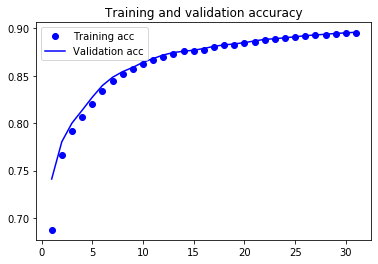

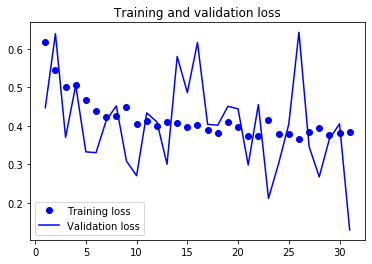

In [46]:
# Plot graph
import matplotlib.pyplot as plt
acc = history_baseline.history['auc']
val_acc = history_baseline.history['val_auc']
loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###### NOTE: It is a Training vs Validation AUC graph, it's an incorrect label. I apologise for the inconvience

### Observation:

Through the training vs validation AUC graph,We can see that the model is not overfitting and has performed well for a baseline model. The training vs validation graphs doesn't seems consistent and we will cater to this as we progress through the use of regularisation and dropout

In [49]:
model_baseline.save('model_baseline')

# 5.3.2 Baseline Model: Using Stain Normalized Images

We will use the same baseline model as before but we will now run our model using Stain normalized images

In [50]:
from keras import layers
from keras import models
import tensorflow as tf

model_baseline_transformed = Sequential()


model_baseline_transformed.add(layers.Flatten(input_shape=(27,27,3)))
model_baseline_transformed.add(layers.Dense(256, activation='relu'))
model_baseline_transformed.add(layers.Dense(2, activation='sigmoid'))
model_baseline_transformed.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=[tf.keras.metrics.AUC()])



In [51]:
train_generator_transformed = train_datagen.flow_from_dataframe(
dataframe=train_data_transformed,
directory="./Image_classification_data/transformed_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=20,
class_mode="categorical",
shuffle= True,
target_size=(27,27))

val_generator_transformed =test_datagen.flow_from_dataframe(
dataframe=val_data_transformed,
directory="./Image_classification_data/transformed_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=20,
class_mode="categorical",
shuffle= True,
target_size=(27,27))

test_generator_transformed =test_datagen.flow_from_dataframe(
dataframe=test_data_transformed,
directory="./Image_classification_data/transformed_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=20,
class_mode="categorical",
shuffle= True,
target_size=(27,27))

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [52]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_baseline_transformed = model_baseline_transformed.fit_generator(
      train_generator_transformed,
      steps_per_epoch=100,
      epochs=100,
      callbacks = [callback],
      validation_data=val_generator_transformed,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 4s 37ms/step - loss: 0.6837 - auc_1: 0.6305 - val_loss: 0.4897 - val_auc_1: 0.6690
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.6480 - auc_1: 0.6840 - val_loss: 0.7181 - val_auc_1: 0.6755
Epoch 3/100
100/100 [==============================] - 3s 30ms/step - loss: 0.6142 - auc_1: 0.6762 - val_loss: 0.6162 - val_auc_1: 0.6817
Epoch 4/100
100/100 [==============================] - 3s 33ms/step - loss: 0.5762 - auc_1: 0.6900 - val_loss: 0.5863 - val_auc_1: 0.7024
Epoch 5/100
100/100 [==============================] - 3s 27ms/step - loss: 0.5683 - auc_1: 0.7105 - val_loss: 0.4944 - val_auc_1: 0.7195
Epoch 6/100
100/100 [==============================] - 3s 27ms/step - loss: 0.5529 - auc_1: 0.7265 - val_loss: 0.5954 - val_auc_1: 0.7337
Epoch 7/100
100/100 [==============================] - 3s 28ms/step - loss: 0.5355 - auc_1: 0.7390 - val_loss: 0.5092 - val_auc_1: 0.7466
Epoch 8/100
100/100 [=============

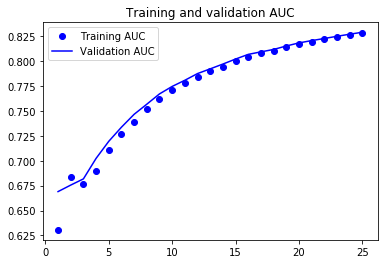

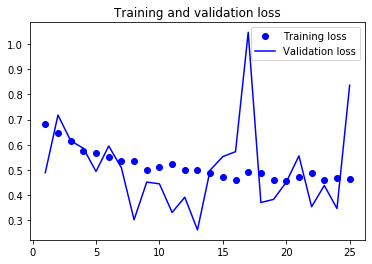

In [53]:
import matplotlib.pyplot as plt
acc = history_baseline_transformed.history['auc_1']
val_acc = history_baseline_transformed.history['val_auc_1']
loss = history_baseline_transformed.history['loss']
val_loss = history_baseline_transformed.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Observation:

The model hasn't performed as good as on the patch images. We will conduct further investigation later through the help of confusion matrix which will help understand if the performance drops because of both the classes or any specific one class.

The training vs validation loss graphs seems to have improve compared to the baseline model run on patch images. But there are instances where the difference between training and validation AUC values are a lot.

In [54]:
model_baseline_transformed.save('model_baseline_transformed')

## 5.3.3 Baseline Model: Multiple Conv2D Layers
Now we will add Conv2D layers and MaxPooling2D layers to our CNN model.
- **Conv2D layer** : Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
- **MaxPooling2D layer** : Max pooling is used to reduce the spatial dimensions.

A Conv2D layer contains a filter. As far as choosing the appropriate value for no. of filters, it is always recommended to use powers of 2 as the values.
For example, our first layer will learn a total of 32 filters.


In [55]:

from keras import layers
from keras import models

model_baseline_multiple = Sequential()
model_baseline_multiple.add(layers.Conv2D(32, (3, 3), padding="same",activation='relu',
                        input_shape=(27, 27, 3)))
model_baseline_multiple.add(layers.MaxPooling2D((2, 2)))
model_baseline_multiple.add(layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
model_baseline_multiple.add(layers.MaxPooling2D((2, 2)))
model_baseline_multiple.add(layers.Conv2D(128, (3, 3),padding="same", activation='relu'))
model_baseline_multiple.add(layers.MaxPooling2D((2, 2)))

model_baseline_multiple.add(layers.Conv2D(128, (3, 3), padding="same",activation='relu'))
model_baseline_multiple.add(layers.MaxPooling2D((2, 2)))
model_baseline_multiple.add(layers.Flatten())
model_baseline_multiple.add(layers.Dense(512, activation='relu'))
model_baseline_multiple.add(layers.Dense(2, activation='sigmoid'))

In [56]:
model_baseline_multiple.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)        

In [57]:
from keras import optimizers
model_baseline_multiple.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=[tf.keras.metrics.AUC()])

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_baseline_multiple = model_baseline_multiple.fit_generator(
      train_generator_baseline,
      steps_per_epoch=100,
      epochs=100,
      validation_data=val_generator_baseline,
      callbacks = [callback],
      validation_steps=50)


Epoch 1/100
100/100 [==============================] - 5s 49ms/step - loss: 0.6261 - auc_2: 0.7119 - val_loss: 0.6509 - val_auc_2: 0.7243
Epoch 2/100
100/100 [==============================] - 4s 37ms/step - loss: 0.6085 - auc_2: 0.7359 - val_loss: 0.6298 - val_auc_2: 0.7444
Epoch 3/100
100/100 [==============================] - 4s 40ms/step - loss: 0.5455 - auc_2: 0.7526 - val_loss: 0.5327 - val_auc_2: 0.7654
Epoch 4/100
100/100 [==============================] - 4s 37ms/step - loss: 0.4837 - auc_2: 0.7805 - val_loss: 0.2918 - val_auc_2: 0.7935
Epoch 5/100
100/100 [==============================] - 3s 35ms/step - loss: 0.4434 - auc_2: 0.8055 - val_loss: 0.2391 - val_auc_2: 0.8153
Epoch 6/100
100/100 [==============================] - 4s 35ms/step - loss: 0.4251 - auc_2: 0.8225 - val_loss: 0.4179 - val_auc_2: 0.8303
Epoch 7/100
100/100 [==============================] - 5s 47ms/step - loss: 0.4106 - auc_2: 0.8370 - val_loss: 0.5011 - val_auc_2: 0.8423
Epoch 8/100
100/100 [=============

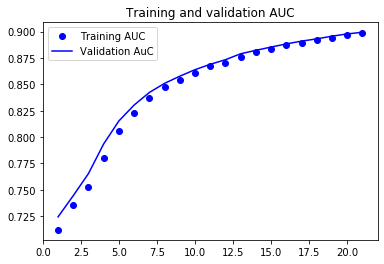

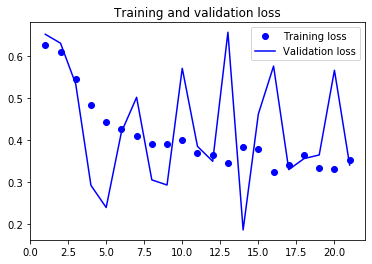

In [59]:


import matplotlib.pyplot as plt
acc = history_baseline_multiple.history['auc_2']
val_acc = history_baseline_multiple.history['val_auc_2']
loss = history_baseline_multiple.history['loss']
val_loss = history_baseline_multiple.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AuC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Observation:

The model hasn't shown significant improvements compared to previous ones. But, The training vs validation AUC graphs shows a high AUC values without overfitting. This may increase if it is run on more epochs and without the use of EarlyStopping


In [60]:
model_baseline_multiple.save('model_baseline_multiple')

# 5.3.4 Baseline Model: Multiple Conv2D layers with Stain Normalized Images

In [61]:
from keras import layers
from keras import models

model_baseline_multiple_transformed = Sequential()
model_baseline_multiple_transformed.add(layers.Conv2D(32, (3, 3), padding="same",activation='relu',
                        input_shape=(27, 27, 3)))
model_baseline_multiple_transformed.add(layers.MaxPooling2D((2, 2)))
model_baseline_multiple_transformed.add(layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
model_baseline_multiple_transformed.add(layers.MaxPooling2D((2, 2)))
model_baseline_multiple_transformed.add(layers.Conv2D(128, (3, 3),padding="same", activation='relu'))
model_baseline_multiple_transformed.add(layers.MaxPooling2D((2, 2)))

model_baseline_multiple_transformed.add(layers.Conv2D(128, (3, 3), padding="same",activation='relu'))
model_baseline_multiple_transformed.add(layers.MaxPooling2D((2, 2)))
model_baseline_multiple_transformed.add(layers.Flatten())
model_baseline_multiple_transformed.add(layers.Dense(512, activation='relu'))
model_baseline_multiple_transformed.add(layers.Dense(2, activation='sigmoid'))
model_baseline_multiple_transformed.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=[tf.keras.metrics.AUC()])

In [62]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_baseline_multiple_transformed = model_baseline_multiple_transformed.fit_generator(
      train_generator_transformed,
      steps_per_epoch=100,
      epochs=44,
      validation_data=val_generator_transformed,
      validation_steps=50)

Epoch 1/44
100/100 [==============================] - 4s 45ms/step - loss: 0.6457 - auc_3: 0.6560 - val_loss: 0.7206 - val_auc_3: 0.6742
Epoch 2/44
100/100 [==============================] - 3s 33ms/step - loss: 0.6501 - auc_3: 0.6767 - val_loss: 0.6818 - val_auc_3: 0.6861
Epoch 3/44
100/100 [==============================] - 3s 34ms/step - loss: 0.6326 - auc_3: 0.6933 - val_loss: 0.5306 - val_auc_3: 0.7059
Epoch 4/44
100/100 [==============================] - 4s 35ms/step - loss: 0.5919 - auc_3: 0.7167 - val_loss: 0.6097 - val_auc_3: 0.7281
Epoch 5/44
100/100 [==============================] - 3s 34ms/step - loss: 0.5349 - auc_3: 0.7387 - val_loss: 0.3919 - val_auc_3: 0.7455
Epoch 6/44
100/100 [==============================] - 4s 38ms/step - loss: 0.5060 - auc_3: 0.7520 - val_loss: 0.3022 - val_auc_3: 0.7615
Epoch 7/44
100/100 [==============================] - 3s 34ms/step - loss: 0.4818 - auc_3: 0.7692 - val_loss: 0.3382 - val_auc_3: 0.7776
Epoch 8/44
100/100 [=====================

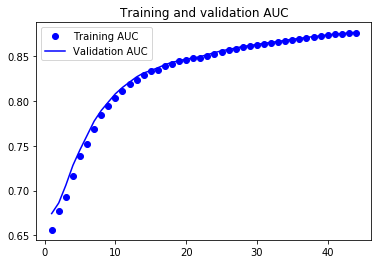

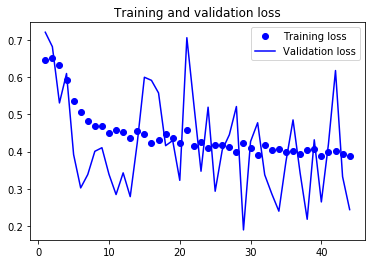

In [63]:

import matplotlib.pyplot as plt
acc = history_baseline_multiple_transformed.history['auc_3']
val_acc = history_baseline_multiple_transformed.history['val_auc_3']
loss = history_baseline_multiple_transformed.history['loss']
val_loss = history_baseline_multiple_transformed.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [65]:
model_baseline_multiple_transformed.save('model_baseline_multiple_transformed')

## 5.3.5 Baseline Model: VGG16 Architecture (Patch Images)

We will now implement a model which has the same architecture as VGG16.

**VGG16** is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is a 16-layer architecture, which is considered to be a great vision model architecture with a top 5 accuracy on the ImageNet database. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. 

In [247]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers



model_2_reg_vgg = models.Sequential()
model_2_reg_vgg.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu',
                        input_shape=(27, 27, 3)))
model_2_reg_vgg.add(layers.Conv2D(32, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg.add(layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg.add(layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg.add(layers.Conv2D(128, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg.add(layers.Conv2D(256, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg.add(layers.Conv2D(256, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg.add(layers.Flatten())
model_2_reg_vgg.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg.add(layers.Dense(2, activation='sigmoid'))
model_2_reg_vgg.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[tf.keras.metrics.AUC()])



In [248]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_reg_vegg = model_2_reg_vgg.fit_generator(
      train_generator_baseline,
      steps_per_epoch=100,
      epochs=50,
      validation_data=val_generator_baseline,

      validation_steps=50)

Epoch 1/50
100/100 [==============================] - 26s 258ms/step - loss: 0.6333 - auc_7: 0.6993 - val_loss: 0.6677 - val_auc_7: 0.7002
Epoch 2/50
100/100 [==============================] - 23s 228ms/step - loss: 0.6279 - auc_7: 0.7024 - val_loss: 0.5885 - val_auc_7: 0.7008
Epoch 3/50
100/100 [==============================] - 27s 267ms/step - loss: 0.5779 - auc_7: 0.7081 - val_loss: 0.4569 - val_auc_7: 0.7278
Epoch 4/50
100/100 [==============================] - 26s 258ms/step - loss: 0.5531 - auc_7: 0.7409 - val_loss: 0.4381 - val_auc_7: 0.7513
Epoch 5/50
100/100 [==============================] - 22s 216ms/step - loss: 0.4881 - auc_7: 0.7626 - val_loss: 0.3574 - val_auc_7: 0.7775
Epoch 6/50
100/100 [==============================] - 21s 214ms/step - loss: 0.4149 - auc_7: 0.7908 - val_loss: 0.2751 - val_auc_7: 0.8043
Epoch 7/50
100/100 [==============================] - 21s 215ms/step - loss: 0.4047 - auc_7: 0.8144 - val_loss: 0.3057 - val_auc_7: 0.8215
Epoch 8/50
100/100 [=======

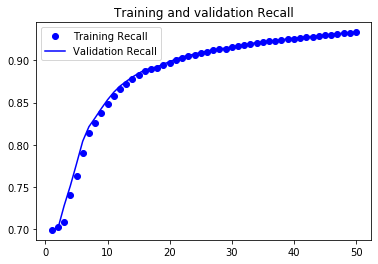

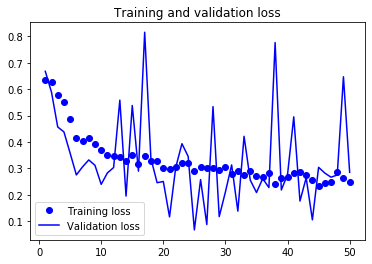

In [249]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
acc = history_reg_vegg.history['auc_7']
val_acc = history_reg_vegg.history['val_auc_7']
loss = history_reg_vegg.history['loss']
val_loss = history_reg_vegg.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation Recall')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### NOTE: This is a Training vs validation AUC graph and not recall, there is a mistake in the labelleing. I appologise for the inconvinence.

#### Observation

We can see through the Training and Validation AUC graph that the performance has increased compared to previous models. Through the help of confusion matrix we will make later, we can make observations about how good the model is in predicting class 0 and 1.

In [72]:
model_2_reg_vgg.save('model_2_reg_vgg')

# 5.3.6 Baseline Model VGG16 Architecture (Stain Normalized)

In [258]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers



model_2_reg_vgg_transformed = models.Sequential()
model_2_reg_vgg_transformed.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu',
                        input_shape=(27, 27, 3)))
model_2_reg_vgg_transformed.add(layers.Conv2D(32, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_transformed.add(layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg_transformed.add(layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_transformed.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg_transformed.add(layers.Conv2D(128, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg_transformed.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_transformed.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg_transformed.add(layers.Conv2D(256, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg_transformed.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_transformed.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg_transformed.add(layers.Conv2D(256, (3, 3), padding="same",activation='relu'))
model_2_reg_vgg_transformed.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model_2_reg_vgg_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_transformed.add(layers.Flatten())
model_2_reg_vgg_transformed.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_transformed.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_transformed.add(layers.Dense(2, activation='sigmoid'))
model_2_reg_vgg_transformed.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[tf.keras.metrics.AUC()])

In [259]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_reg_vegg_transformed = model_2_reg_vgg_transformed.fit_generator(
      train_generator_transformed,
      steps_per_epoch=100,
      epochs=50,
      validation_data=val_generator_transformed,

      validation_steps=50)

Epoch 1/50
100/100 [==============================] - 28s 275ms/step - loss: 0.6637 - auc_8: 0.6398 - val_loss: 0.5862 - val_auc_8: 0.6537
Epoch 2/50
100/100 [==============================] - 22s 219ms/step - loss: 0.6479 - auc_8: 0.6659 - val_loss: 0.6091 - val_auc_8: 0.6645
Epoch 3/50
100/100 [==============================] - 25s 251ms/step - loss: 0.6371 - auc_8: 0.6707 - val_loss: 0.5249 - val_auc_8: 0.6794
Epoch 4/50
100/100 [==============================] - 30s 299ms/step - loss: 0.5407 - auc_8: 0.6965 - val_loss: 0.6458 - val_auc_8: 0.7176
Epoch 5/50
100/100 [==============================] - 26s 261ms/step - loss: 0.5028 - auc_8: 0.7341 - val_loss: 0.6022 - val_auc_8: 0.7483
Epoch 6/50
100/100 [==============================] - 21s 214ms/step - loss: 0.4863 - auc_8: 0.7604 - val_loss: 0.6957 - val_auc_8: 0.7683
Epoch 7/50
100/100 [==============================] - 21s 208ms/step - loss: 0.4465 - auc_8: 0.7758 - val_loss: 0.4549 - val_auc_8: 0.7858
Epoch 8/50
100/100 [=======

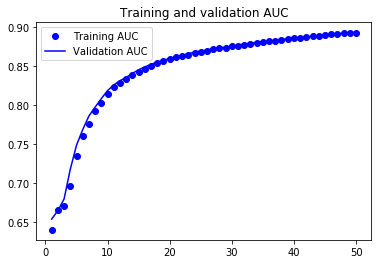

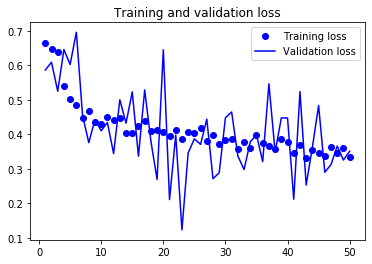

In [260]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
acc = history_reg_vegg_transformed.history['auc_8']
val_acc = history_reg_vegg_transformed.history['val_auc_8']
loss = history_reg_vegg_transformed.history['loss']
val_loss = history_reg_vegg_transformed.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [262]:
model_2_reg_vgg_transformed.save('model_2_reg_vgg_transformed')

# 5.3.7 VGG16 Optimized with droupout and regualrize (Patch Images)

- **Dropout** : Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporarily removed. The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.

- **Regularize** : L2 regularization optimizes the mean cost (whereas L1 reduces the median explanation) which is often used as a performance measurement. This is especially good if you know you don't have any outliers and you want to keep the overall error small. The solution is more likely to be unique.
https://stackoverflow.com/questions/32276391/feature-normalization-advantage-of-l2-normalization

In [263]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers

reg_lambda = 0.001

model_2_reg_vgg_optimized = models.Sequential()
model_2_reg_vgg_optimized.add(layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu',
                        input_shape=(27, 27, 3)))
model_2_reg_vgg_optimized.add(layers.Conv2D(32, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized.add(layers.Conv2D(64, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized.add(layers.Conv2D(64, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized.add(layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized.add(layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized.add(layers.Flatten())
model_2_reg_vgg_optimized.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_optimized.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_optimized.add(layers.Dropout(0.5))
model_2_reg_vgg_optimized.add(layers.Dense(2, activation='sigmoid'))
model_2_reg_vgg_optimized.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[tf.keras.metrics.AUC()])



In [264]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_reg_vegg_tuned_batch = model_2_reg_vgg_optimized.fit_generator(
      train_generator_baseline,
      steps_per_epoch=100,
      epochs=70,
      validation_data=val_generator_baseline,
#       callbacks=[callback],
      validation_steps=50)

Epoch 1/70
100/100 [==============================] - 29s 294ms/step - loss: 2.0176 - auc_9: 0.6303 - val_loss: 1.6822 - val_auc_9: 0.6681
Epoch 2/70
100/100 [==============================] - 25s 249ms/step - loss: 1.3718 - auc_9: 0.6787 - val_loss: 1.1278 - val_auc_9: 0.6777
Epoch 3/70
100/100 [==============================] - 23s 231ms/step - loss: 1.0052 - auc_9: 0.6881 - val_loss: 0.8734 - val_auc_9: 0.7049
Epoch 4/70
100/100 [==============================] - 23s 232ms/step - loss: 0.8346 - auc_9: 0.7236 - val_loss: 0.8979 - val_auc_9: 0.7310
Epoch 5/70
100/100 [==============================] - 23s 234ms/step - loss: 0.7611 - auc_9: 0.7399 - val_loss: 0.5925 - val_auc_9: 0.7505
Epoch 6/70
100/100 [==============================] - 24s 236ms/step - loss: 0.7054 - auc_9: 0.7616 - val_loss: 0.6409 - val_auc_9: 0.7711
Epoch 7/70
100/100 [==============================] - 23s 234ms/step - loss: 0.6913 - auc_9: 0.7793 - val_loss: 0.6338 - val_auc_9: 0.7859
Epoch 8/70
100/100 [=======

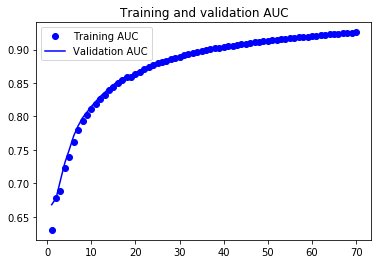

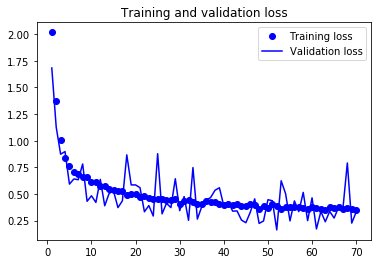

In [265]:

import matplotlib.pyplot as plt
acc = history_reg_vegg_tuned_batch.history['auc_9']
val_acc = history_reg_vegg_tuned_batch.history['val_auc_9']
loss = history_reg_vegg_tuned_batch.history['loss']
val_loss = history_reg_vegg_tuned_batch.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Observation

A Clear iimprovment in the training vs validation loss graph is seen and the values are not overfitting anymore. There loss margin generally oscillates from 0.25 to 1. We can make better judgment if this helps in prediction of class 0 and 1s later, looking at the confusion matrix

In [267]:
model_2_reg_vgg_optimized.save('model_2_reg_vgg_optimized')

# 5.3.8 VGG16 Optimized model with dropout and regularize (Stain Normalized Images)

In [268]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers

reg_lambda = 0.001

model_2_reg_vgg_optimized_transformed = models.Sequential()
model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu',
                        input_shape=(27, 27, 3)))
model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(32, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(64, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(64, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed.add(layers.Flatten())
model_2_reg_vgg_optimized_transformed.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_optimized_transformed.add(layers.Dropout(0.5))
model_2_reg_vgg_optimized_transformed.add(layers.Dense(2, activation='sigmoid'))
model_2_reg_vgg_optimized_transformed.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[tf.keras.metrics.AUC()])



In [269]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_reg_vegg_tuned_batch_transformed = model_2_reg_vgg_optimized_transformed.fit_generator(
      train_generator_transformed,
      steps_per_epoch=100,
      epochs=69,
      validation_data=val_generator_transformed,
#       callbacks=[callback],
      validation_steps=50)

Epoch 1/69
100/100 [==============================] - 27s 269ms/step - loss: 2.0376 - auc_10: 0.6362 - val_loss: 1.6374 - val_auc_10: 0.6585
Epoch 2/69
100/100 [==============================] - 24s 241ms/step - loss: 1.3862 - auc_10: 0.6628 - val_loss: 1.0818 - val_auc_10: 0.6711
Epoch 3/69
100/100 [==============================] - 24s 240ms/step - loss: 1.0530 - auc_10: 0.6719 - val_loss: 0.9929 - val_auc_10: 0.6719
Epoch 4/69
100/100 [==============================] - 24s 241ms/step - loss: 0.9206 - auc_10: 0.6685 - val_loss: 0.7433 - val_auc_10: 0.6690
Epoch 5/69
100/100 [==============================] - 24s 242ms/step - loss: 0.8463 - auc_10: 0.6727 - val_loss: 0.7521 - val_auc_10: 0.6803
Epoch 6/69
100/100 [==============================] - 24s 240ms/step - loss: 0.7854 - auc_10: 0.6893 - val_loss: 0.6329 - val_auc_10: 0.6962
Epoch 7/69
100/100 [==============================] - 24s 239ms/step - loss: 0.7853 - auc_10: 0.7009 - val_loss: 0.7072 - val_auc_10: 0.7047
Epoch 8/69
10

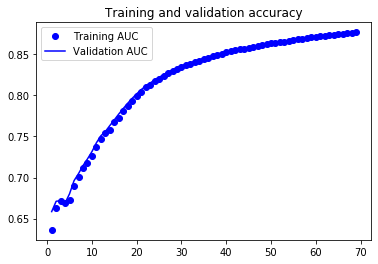

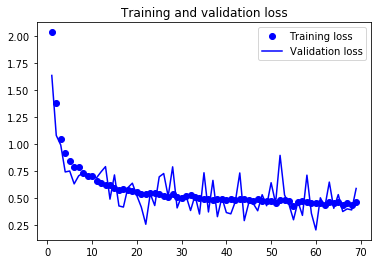

In [270]:
import matplotlib.pyplot as plt

acc = history_reg_vegg_tuned_batch_transformed.history['auc_10']
val_acc = history_reg_vegg_tuned_batch_transformed.history['val_auc_10']
loss = history_reg_vegg_tuned_batch_transformed.history['loss']
val_loss = history_reg_vegg_tuned_batch_transformed.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [272]:
model_2_reg_vgg_optimized_transformed.save('model_2_reg_vgg_optimized_transformed')

## 5.3.9 VGG16 Optimized model with Image Data Augmentation (Patch Images)

Data augmentation is a technique to artificially create new training data from existing training data. This is done by applying domain-specific techniques to examples from the training data that create new and different training examples.

Image data augmentation is perhaps the most well-known type of data augmentation and involves creating transformed versions of images in the training dataset that belong to the same class as the original image.

Transforms include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more.

##### Why Image Data Augmentation? 
Since we have a relatively low number of training images (20K) compared to the 1 million images for ImageNet, for this model, we apply data augmentation to our training dataset to increase the number of training samples by applying a number of random transformations which helps expose the model to more aspects of the data and generalize better.

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [273]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers

reg_lambda = 0.001

model_2_reg_vgg_optimized_ia = models.Sequential()
model_2_reg_vgg_optimized_ia.add(layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu',
                        input_shape=(27, 27, 3)))
model_2_reg_vgg_optimized_ia.add(layers.Conv2D(32, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_ia.add(layers.Conv2D(64, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.Conv2D(64, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_ia.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_ia.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_ia.add(layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_ia.add(layers.Flatten())
model_2_reg_vgg_optimized_ia.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_optimized_ia.add(layers.Dropout(0.5))
model_2_reg_vgg_optimized_ia.add(layers.Dense(2, activation='sigmoid'))
model_2_reg_vgg_optimized_ia.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[tf.keras.metrics.AUC()])

In [274]:
train_datagen_tune = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen_tune = ImageDataGenerator(rescale=1./255)

In [275]:
train_generator_tune=train_datagen_tune.flow_from_dataframe(
dataframe=train_data,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=32,
class_mode="categorical",
shuffle=True,
target_size=(27,27))

val_generator_tune=test_datagen_tune.flow_from_dataframe(
dataframe=val_data,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=32,
class_mode="categorical",
shuffle=True,
target_size=(27,27))

test_generator_tune =test_datagen_tune.flow_from_dataframe(
dataframe=test_data,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="isCancerous",
batch_size =32,
class_mode="categorical",
shuffle=True,
target_size=(27,27))

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [276]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_reg_vegg_tuned_batch_ia = model_2_reg_vgg_optimized_ia.fit_generator(
      train_generator_tune,
      steps_per_epoch=100,
      epochs=70,
      validation_data=val_generator_tune,

      validation_steps=50)

Epoch 1/70
100/100 [==============================] - 43s 430ms/step - loss: 1.9957 - auc_11: 0.6245 - val_loss: 1.6009 - val_auc_11: 0.6737
Epoch 2/70
100/100 [==============================] - 35s 355ms/step - loss: 1.3359 - auc_11: 0.6861 - val_loss: 1.1024 - val_auc_11: 0.6880
Epoch 3/70
100/100 [==============================] - 33s 330ms/step - loss: 1.0095 - auc_11: 0.6890 - val_loss: 0.7955 - val_auc_11: 0.7010
Epoch 4/70
100/100 [==============================] - 37s 374ms/step - loss: 0.8077 - auc_11: 0.7157 - val_loss: 0.8845 - val_auc_11: 0.7222
Epoch 5/70
100/100 [==============================] - 38s 384ms/step - loss: 0.7577 - auc_11: 0.7281 - val_loss: 0.5484 - val_auc_11: 0.7386
Epoch 6/70
100/100 [==============================] - 35s 346ms/step - loss: 0.7333 - auc_11: 0.7455 - val_loss: 0.7360 - val_auc_11: 0.7531
Epoch 7/70
100/100 [==============================] - 31s 314ms/step - loss: 0.6963 - auc_11: 0.7599 - val_loss: 0.4501 - val_auc_11: 0.7665
Epoch 8/70
10

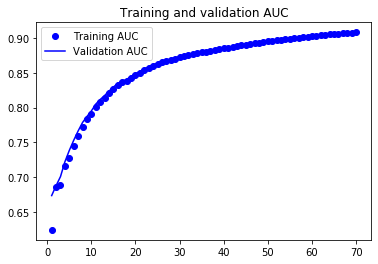

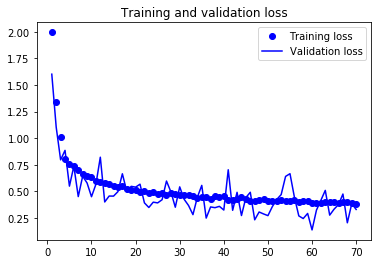

In [277]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
acc = history_reg_vegg_tuned_batch_ia.history['auc_11']
val_acc = history_reg_vegg_tuned_batch_ia.history['val_auc_11']
loss = history_reg_vegg_tuned_batch_ia.history['loss']
val_loss = history_reg_vegg_tuned_batch_ia.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [279]:
model_2_reg_vgg_optimized_ia.save('model_2_reg_vgg_optimized_ia')

# 5.3.10 VGG16 Optimized model with Image Data Augmentation (Stain Normalized Images)

In [280]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers

reg_lambda = 0.001

model_2_reg_vgg_optimized_transformed_ia = models.Sequential()
model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu',
                        input_shape=(27, 27, 3)))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(32, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(64, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(64, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Conv2D(256, (3, 3), padding="same",kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'))

model_2_reg_vgg_optimized_transformed_ia.add(layers.Flatten())
model_2_reg_vgg_optimized_transformed_ia.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Dense(512, activation='relu'))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Dropout(0.5))
model_2_reg_vgg_optimized_transformed_ia.add(layers.Dense(2, activation='sigmoid'))
model_2_reg_vgg_optimized_transformed_ia.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[tf.keras.metrics.AUC()])

In [281]:
train_generator_tune_transformed=train_datagen_tune.flow_from_dataframe(
dataframe=train_data_transformed,
directory="./Image_classification_data/transformed_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=32,
class_mode="categorical",
shuffle=True,
target_size=(27,27))

val_generator_tune_transformed=test_datagen_tune.flow_from_dataframe(
dataframe=val_data_transformed,
directory="./Image_classification_data/transformed_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=32,
class_mode="categorical",
shuffle=True,
target_size=(27,27))

test_generator_tune_transformed =test_datagen_tune.flow_from_dataframe(
dataframe=test_data_transformed,
directory="./Image_classification_data/transformed_images",
x_col="ImageName",
y_col="isCancerous",
batch_size =32,
class_mode="categorical",
shuffle=True,
target_size=(27,27))

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [282]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history_reg_vegg_tuned_batch_ia_transformed = model_2_reg_vgg_optimized_transformed_ia.fit_generator(
      train_generator_tune_transformed,
      steps_per_epoch=100,
      epochs=70,
      validation_data=val_generator_tune_transformed,

      validation_steps=50)

Epoch 1/70
100/100 [==============================] - 34s 339ms/step - loss: 2.0203 - auc_12: 0.6414 - val_loss: 1.5781 - val_auc_12: 0.6503
Epoch 2/70
100/100 [==============================] - 31s 310ms/step - loss: 1.3524 - auc_12: 0.6575 - val_loss: 1.0581 - val_auc_12: 0.6573
Epoch 3/70
100/100 [==============================] - 31s 311ms/step - loss: 1.0090 - auc_12: 0.6605 - val_loss: 0.8196 - val_auc_12: 0.6632
Epoch 4/70
100/100 [==============================] - 31s 311ms/step - loss: 0.8585 - auc_12: 0.6655 - val_loss: 0.8105 - val_auc_12: 0.6687
Epoch 5/70
100/100 [==============================] - 31s 311ms/step - loss: 0.7971 - auc_12: 0.6738 - val_loss: 0.7542 - val_auc_12: 0.6778
Epoch 6/70
100/100 [==============================] - 31s 310ms/step - loss: 0.7539 - auc_12: 0.6838 - val_loss: 0.7953 - val_auc_12: 0.6870
Epoch 7/70
100/100 [==============================] - 31s 313ms/step - loss: 0.7474 - auc_12: 0.6896 - val_loss: 0.6469 - val_auc_12: 0.6941
Epoch 8/70
10

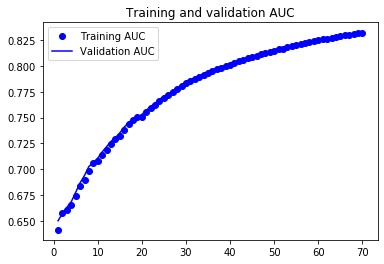

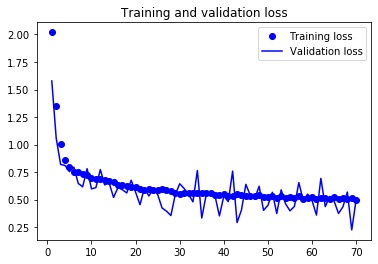

In [283]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
acc = history_reg_vegg_tuned_batch_ia_transformed.history['auc_12']
val_acc = history_reg_vegg_tuned_batch_ia_transformed.history['val_auc_12']
loss = history_reg_vegg_tuned_batch_ia_transformed.history['loss']
val_loss = history_reg_vegg_tuned_batch_ia_transformed.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [285]:
model_2_reg_vgg_optimized_transformed_ia.save('model_2_reg_vgg_optimized_transformed_ia')

# 6. Evaluation and Ultimate Judgement

Let us know evaluate our models by building confusion matrix and classification reports

### Validation Data generator without Image augmentation

In [210]:
val_generator_transformed_eval =test_datagen.flow_from_dataframe(
dataframe=val_data_transformed,
directory="./Image_classification_data/transformed_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=1,
class_mode="categorical",
shuffle=False,    
target_size=(27,27))

Found 4056 validated image filenames belonging to 2 classes.


In [211]:
val_generator_eval =test_datagen.flow_from_dataframe(
dataframe=val_data,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=1,
class_mode="categorical",
shuffle=False, 
target_size=(27,27))

Found 4056 validated image filenames belonging to 2 classes.


In [99]:
test_y_temp = test_y.astype(int)
val_y_temp = val_y.astype(int)

In [100]:
t= test_y.astype(int)

## Baseline model 1 Layer (Patch Images)

In [271]:
import sklearn.metrics as metrics
from sklearn import metrics

In [241]:
predict_baseline = model_baseline.predict_generator(val_generator_eval,steps = len(val_generator_eval.filenames), workers=0)


In [242]:
predicted_class_indices_baseline=np.argmax(predict_baseline,axis=1)

In [243]:
predicted_class_indices_baseline

array([0, 0, 0, ..., 0, 0, 0])

In [244]:
confusion_matrix_baseline = metrics.confusion_matrix(y_true=val_generator_eval.classes, y_pred=predicted_class_indices_baseline)
print(confusion_matrix_baseline)


[[2407  274]
 [ 299 1076]]


In [245]:
true_classes = val_generator_eval.classes
class_labels = list(val_generator_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_class_indices_baseline, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2681
           1       0.80      0.78      0.79      1375

    accuracy                           0.86      4056
   macro avg       0.84      0.84      0.84      4056
weighted avg       0.86      0.86      0.86      4056



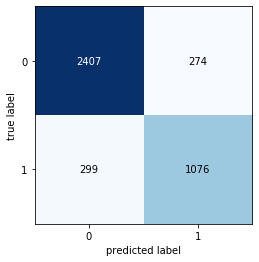

In [2]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary1 = np.array([[2407, 274],
                   [299, 1076]])
fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.show()

### Observations:

We can see that the baseline model has performed well. The number of true positive and true negative samples are very high showing how well the model is classifing class 0 and class 1. We can see a high precision and high recall for class 0 but not as high for class 1 which is not optimal for a real world scenario as this
model doesn't misclassify healthy patients and but wrongly leave out the cancer patients

## Baseline model 1 layer (Stain Normalised Images)

In [235]:
predict_baseline_transformed = model_baseline_transformed.predict_generator(val_generator_transformed_eval,steps = len(val_generator_transformed_eval.filenames), workers=0)


In [236]:
predicted_class_indices_baseline_transformed=np.argmax(predict_baseline_transformed,axis=1)

In [237]:
predicted_class_indices_baseline_transformed

array([0, 0, 0, ..., 0, 0, 0])

In [238]:
confusion_matrix_baseline_transformed = metrics.confusion_matrix(y_true=val_generator_transformed_eval.classes, y_pred=predicted_class_indices_baseline_transformed)
print(confusion_matrix_baseline_transformed)


[[2592   89]
 [ 770  605]]


In [239]:
true_classes = val_generator_transformed_eval.classes
class_labels = list(val_generator_transformed_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_class_indices_baseline_transformed, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      2681
           1       0.87      0.44      0.58      1375

    accuracy                           0.79      4056
   macro avg       0.82      0.70      0.72      4056
weighted avg       0.81      0.79      0.77      4056



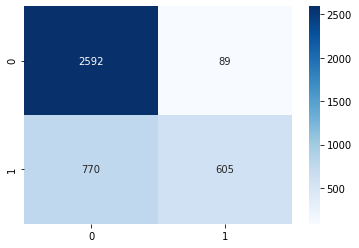

In [240]:
import seaborn as sns
sns.heatmap(confusion_matrix_baseline_transformed, annot=True,cmap='Blues', fmt='g')

### Observations:

We can see that the model has performed exceptionally well for predicting class 0 but has done extremely poor for class 1. Through this we can make an assumption that stain normalisation helps improve prediction of class 0. We will furthur explore this after reviewing other models.
The poor performance for class 1 could be possible because of the class imbalance which we saw during the EDA( class 1 has almost half the number the class 0 samples)

This model is not ideal for real world as this model doesn't misclassify healthy patients and but has a very high rate of incorrectly leaving out the cancer patients

## Baseline model multiple Conv2D layers (Patch Images)

In [229]:
predict_baseline_multiple = model_baseline_multiple.predict_generator(val_generator_eval,steps = len(val_generator_eval.filenames), workers=0)


In [230]:
predicted_class_indices_baseline_multiple=np.argmax(predict_baseline_multiple,axis=1)

In [231]:
predicted_class_indices_baseline_multiple

array([0, 0, 0, ..., 0, 0, 0])

In [232]:
confusion_matrix_baseline_multiple = metrics.confusion_matrix(y_true=val_generator_eval.classes, y_pred=predicted_class_indices_baseline_multiple)
print(confusion_matrix_baseline_multiple)


[[2576  105]
 [ 467  908]]


In [233]:
true_classes = val_generator_eval.classes
class_labels = list(val_generator_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_class_indices_baseline_multiple, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      2681
           1       0.90      0.66      0.76      1375

    accuracy                           0.86      4056
   macro avg       0.87      0.81      0.83      4056
weighted avg       0.86      0.86      0.85      4056



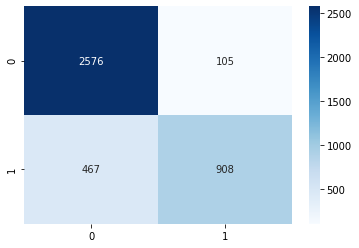

In [234]:
import seaborn as sns
sns.heatmap(confusion_matrix_baseline_multiple, annot=True,cmap='Blues', fmt='g')

### Observations:

We can see that the model has performed exceptionally well for predicting class 0 but has done extremely poor for class 1 again.
This shows that adding Conv2D layers helped improve classification of one of the class by extracting much more common features and in-depth features. 
The poor performance for class 1 could be possible because of the class imbalance which we saw during the EDA( class 1 has almost half the number the class 0 samples)

## Baseline model Conv2D (Transformed)

In [223]:
predict_baseline_multiple_transformed = model_baseline_multiple_transformed.predict_generator(val_generator_transformed_eval,steps = len(val_generator_transformed_eval.filenames), workers=0)


In [224]:
predicted_class_indices_baseline_multiple_transformed = np.argmax(predict_baseline_multiple_transformed,axis=1)

In [225]:
predicted_class_indices_baseline_multiple_transformed

array([0, 0, 0, ..., 0, 0, 0])

In [226]:
confusion_matrix_baseline_multiple_transformed = metrics.confusion_matrix(y_true=val_generator_transformed_eval.classes, y_pred=predicted_class_indices_baseline_multiple_transformed)
print(confusion_matrix_baseline_multiple_transformed)


[[2518  163]
 [ 506  869]]


In [227]:
true_classes = val_generator_transformed_eval.classes
class_labels = list(val_generator_transformed_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_class_indices_baseline_multiple_transformed, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      2681
           1       0.84      0.63      0.72      1375

    accuracy                           0.84      4056
   macro avg       0.84      0.79      0.80      4056
weighted avg       0.84      0.84      0.83      4056



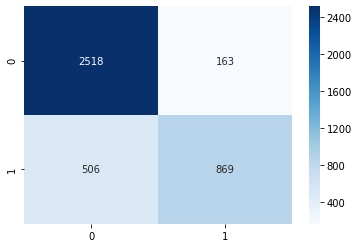

In [228]:
import seaborn as sns
sns.heatmap(confusion_matrix_baseline_multiple_transformed, annot=True,cmap='Blues', fmt='g')

### Observation:

Though, there seem to be not much of a difference between models trained by stained images and patch images, one trend which this model followed is showing a poor performance for class 1. This makes up for a strong evidence that stain normalisation isnt' helping in improving performance for class 1. 

## Baseline Vgg16 Architecture(Patch Images)

In [251]:
predict_baseline_vgg = model_2_reg_vgg.predict_generator(val_generator_eval,steps = len(val_generator_eval.filenames), workers=0)
                                                                                  
                                                                                  

In [252]:
predicted_class_indices_baseline_vgg = np.argmax(predict_baseline_vgg,axis=1)



In [253]:
predicted_class_indices_baseline_vgg

array([0, 0, 0, ..., 0, 0, 0])

In [254]:
true_classes_baseline_vgg = val_generator_eval.classes

In [255]:
confusion_matrix_baseline_vgg = metrics.confusion_matrix(y_true=true_classes_baseline_vgg, y_pred=predicted_class_indices_baseline_vgg)
print(confusion_matrix_baseline_vgg)

[[2420  261]
 [ 169 1206]]


In [256]:

class_labels = list(val_generator_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes_baseline_vgg, predicted_class_indices_baseline_vgg, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      2681
           1       0.82      0.88      0.85      1375

    accuracy                           0.89      4056
   macro avg       0.88      0.89      0.88      4056
weighted avg       0.90      0.89      0.89      4056



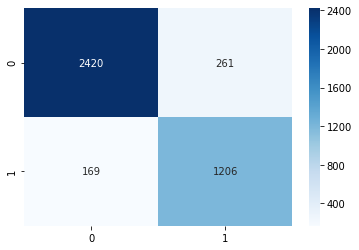

In [257]:
import seaborn as sns
sns.heatmap(confusion_matrix_baseline_vgg, annot=True,cmap='Blues', fmt='g')

### Observation

This has been the best model so far. The true postive and true negative samples are the heighest.
We can see High recall and high precision for classifying images correctly, showing how well this model would work in a real world scenario. This means that the model doesn't misclassify healthy patients and doesn’t wrongly leave out the cancer patients

## Baseline Vgg16 Architecture (Transformed)

In [286]:
predict_baseline_vgg_transformed = model_2_reg_vgg_transformed.predict_generator(val_generator_transformed_eval,steps = len(val_generator_transformed_eval.filenames), workers=0)



In [287]:
predicted_class_indices_baseline_vgg_transformed = np.argmax(predict_baseline_vgg_transformed,axis=1)

In [288]:
predicted_class_indices_baseline_vgg_transformed

array([0, 0, 0, ..., 0, 1, 0])

In [289]:
true_classes_vgg_transformed = val_generator_transformed_eval.classes

In [290]:
confusion_matrix_baseline_vgg_transformed = metrics.confusion_matrix(y_true=true_classes_vgg_transformed, y_pred=predicted_class_indices_baseline_vgg_transformed)
print(confusion_matrix_baseline_vgg_transformed)


[[2413  268]
 [ 372 1003]]


In [291]:

class_labels = list(val_generator_transformed_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes_vgg_transformed, predicted_class_indices_baseline_vgg_transformed, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2681
           1       0.79      0.73      0.76      1375

    accuracy                           0.84      4056
   macro avg       0.83      0.81      0.82      4056
weighted avg       0.84      0.84      0.84      4056



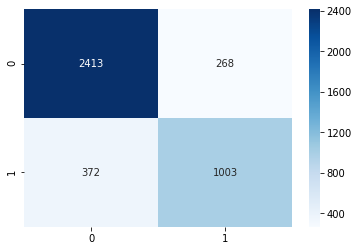

In [292]:
import seaborn as sns
sns.heatmap(confusion_matrix_baseline_vgg_transformed, annot=True,cmap='Blues', fmt='g')

### Observation:

One trend which this model followed is showing a poor performance for class 1. This makes up for a strong evidence that stain normalisation isnt' helping in improving performance for class 1. 

## Vgg16 Optimized(Patched)

In [293]:
predict_vgg_optimized = model_2_reg_vgg_optimized.predict_generator(val_generator_eval,steps = len(val_generator_eval.filenames),workers=0)



In [294]:
predicted_class_indices_vgg_optimized = np.argmax(predict_vgg_optimized,axis=1)

In [295]:
predicted_class_indices_vgg_optimized

array([0, 0, 0, ..., 0, 0, 0])

In [296]:
true_classes_vgg_optimized = val_generator_eval.classes

In [300]:
confusion_matrix_vgg_optimized = metrics.confusion_matrix(y_true=true_classes_vgg_optimized, y_pred=predicted_class_indices_vgg_optimized)
print(confusion_matrix_vgg_optimized)


[[2508  173]
 [ 305 1070]]


In [298]:

class_labels = list(val_generator_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes_vgg_optimized, predicted_class_indices_vgg_optimized, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2681
           1       0.86      0.78      0.82      1375

    accuracy                           0.88      4056
   macro avg       0.88      0.86      0.87      4056
weighted avg       0.88      0.88      0.88      4056



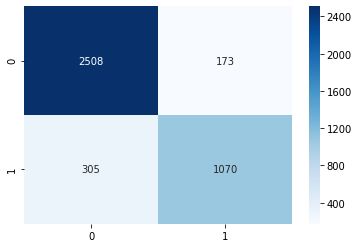

In [301]:
import seaborn as sns
sns.heatmap(confusion_matrix_vgg_optimized, annot=True,cmap='Blues', fmt='g')

### Observations:

We can see that the model has performed exceptionally well for predicting class 0 but hasn't performed that well predicting for class 1. 
The poor performance for class 1 could be possible because of the class imbalance which we saw during the EDA( class 1 has almost half the number the class 0 samples)

This model is not ideal for real world as this model doesn't misclassify healthy patients and but has a very high rate of incorrectly leaving out the cancer patients

## Vgg16 Optimized(Transformed)

In [302]:
predict_vgg_optimized_transformed = model_2_reg_vgg_optimized_transformed.predict_generator(val_generator_transformed_eval,steps = len(val_generator_transformed_eval.filenames),workers=0)


In [303]:
predicted_class_indices_vgg_optimized_transformed = np.argmax(predict_vgg_optimized_transformed,axis=1)

In [304]:
predicted_class_indices_vgg_optimized_transformed

array([0, 0, 0, ..., 0, 0, 0])

In [305]:
true_classes_vgg_optimized_transformed = val_generator_transformed_eval.classes

In [306]:
confusion_matrix_vgg_optimized_transformed = metrics.confusion_matrix(y_true=true_classes_vgg_optimized_transformed, y_pred=predicted_class_indices_vgg_optimized_transformed)
print(confusion_matrix_vgg_optimized_transformed)



[[2571  110]
 [ 627  748]]


In [307]:
# true_classes = val_generator_transformed_eval.classes
class_labels = list(val_generator_transformed_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes_vgg_optimized_transformed, predicted_class_indices_vgg_optimized_transformed, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      2681
           1       0.87      0.54      0.67      1375

    accuracy                           0.82      4056
   macro avg       0.84      0.75      0.77      4056
weighted avg       0.83      0.82      0.81      4056



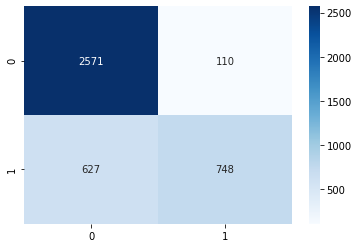

In [308]:
import seaborn as sns
sns.heatmap(confusion_matrix_vgg_optimized_transformed, annot=True,cmap='Blues', fmt='g')

### Observation:

A high recall value for class 0 shows the difference from using stain normalisation. On average, there is a 0.01 to 0.02% increase for class 0 from patch images to stain normalised images.
As we would like to emphasie more on class 1, this model is not suitable for our task as a model with High precision but low recall (class 1) means the doesn’t generate a lot of false positives but misses out on a lot of the real cancer patients

## Vgg16 + Regularisation + Image Augmentation (normal images)

In [309]:
predict_vgg_optimized_augment = model_2_reg_vgg_optimized_ia.predict_generator(val_generator_eval,steps = len(val_generator_eval.filenames),workers=0)



In [310]:
predicted_class_indices_vgg_optimized_augment = np.argmax(predict_vgg_optimized_augment,axis=1)

In [311]:
predicted_class_indices_vgg_optimized_augment

array([0, 0, 0, ..., 0, 0, 0])

In [312]:
true_classes_vgg_ia = val_generator_eval.classes

In [313]:
confusion_matrix_vgg_optimized_augment = metrics.confusion_matrix(y_true=true_classes_vgg_ia, y_pred=predicted_class_indices_vgg_optimized_augment)
print(confusion_matrix_vgg_optimized_augment)


[[2541  140]
 [ 291 1084]]


In [314]:
# true_classes = val_generator_eval.classes
class_labels = list(val_generator_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes_vgg_ia, predicted_class_indices_vgg_optimized_augment, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2681
           1       0.89      0.79      0.83      1375

    accuracy                           0.89      4056
   macro avg       0.89      0.87      0.88      4056
weighted avg       0.89      0.89      0.89      4056



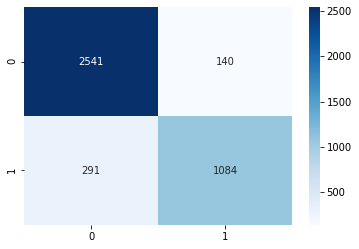

In [315]:
import seaborn as sns
sns.heatmap(confusion_matrix_vgg_optimized_augment, annot=True,cmap='Blues', fmt='g')

### Observation:

A model with High precision but low recall (class 1) means the model is very picky. It doesn’t generate a lot of false positives but misses out on a lot of the real cancer patients. Such models cannot be used for life critical data.

## Vgg16 + Regularisation + Image Augmentation (Stain Normalised images)

In [316]:
predict_vgg_optimized_augment_transformed = model_2_reg_vgg_optimized_transformed_ia.predict_generator(val_generator_transformed_eval,steps = len(val_generator_transformed_eval.filenames),workers=0)



In [317]:
predicted_class_indices_vgg_optimized_augment_transformed = np.argmax(predict_vgg_optimized_augment_transformed,axis=1)


In [318]:
predicted_class_indices_vgg_optimized_augment_transformed

array([0, 0, 0, ..., 0, 0, 0])

In [319]:
true_classes_vgg_ia_transformed = val_generator_transformed_eval.classes

In [320]:
confusion_matrix_vgg_optimized_augment_transformed = metrics.confusion_matrix(y_true=true_classes_vgg_ia_transformed, y_pred=predicted_class_indices_vgg_optimized_augment_transformed)
print(confusion_matrix_vgg_optimized_augment_transformed)


[[2545  136]
 [ 674  701]]


In [321]:
# true_classes = val_generator_transformed_eval.classes
class_labels = list(val_generator_transformed_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes_vgg_ia_transformed, predicted_class_indices_vgg_optimized_augment_transformed, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      2681
           1       0.84      0.51      0.63      1375

    accuracy                           0.80      4056
   macro avg       0.81      0.73      0.75      4056
weighted avg       0.81      0.80      0.79      4056



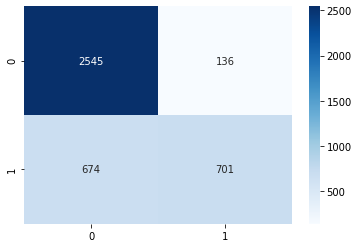

In [322]:
import seaborn as sns
sns.heatmap(confusion_matrix_vgg_optimized_augment_transformed, annot=True,cmap='Blues', fmt='g')

### Observation:

Even though we had used image data augmentation, this model has one of the worst performance. We can definatley make a conclusion after seeing this model that stain normalisation is showing a decline in performance for class 1.

# 6.1 Ultimate Judgement and Prediction on test set

We will choose a model with **High Precision + High Recall**.
Because the prediction model is highly dependable. The model doesn't misclassify healthy patients and doesn’t wrongly leave out the cancer patients


To compare Real world machine learning models responsible for classifying colon cancer, 
 the metric we choose is recall. Recall ensures that we are not overlooking the people who have cancer,
 while precision ensures that we are not misclassifying too many people as having cancer when they don't.
 In this case, we don't want to incorrectly predict a person does not have cancer when they do. 
Thus we will prioritize "recall" as evaluation metric. 
- Stain normalization increases the accuracy/performance of the model predicting class 0 that is not cancerous. But it has a  reverse effect on images that do show cancer. 
- Baseline VGG16 with on patched images has a recall of 88% for class 1/ isCancerous. Whereas VGG16 optimized has a recall of 78%. 
These are the only two models with the highest recall predicting cancerous images. 
Since these two values are comparable, we can then look at their training vs validation AUC graph. We can see that VGG16 baseline on patched images does not overfit. AUC line in VGG16 baseline graph training and validation almost overlaps. Hence this will be our final model.



In [27]:
test_generator_eval =test_datagen.flow_from_dataframe(
dataframe=test_data,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="isCancerous",
batch_size=1,
class_mode="categorical",
shuffle=False,
target_size=(27,27))

Found 4056 validated image filenames belonging to 2 classes.


In [396]:
from tensorflow import keras

load_model = keras.models.load_model('./model_2_reg_vgg')


In [40]:
predict_vgg_load = load_model.predict_generator(test_generator_eval,steps = len(test_generator_eval.filenames), workers=0)



In [41]:
predicted = np.argmax(predict_vgg_load,axis=1)


In [42]:
true_classes_e = test_generator_eval.classes

In [45]:
confusion_matrix_vgg_optimized_test = metrics.confusion_matrix(y_true=true_classes_e, y_pred=predicted)
print(confusion_matrix_vgg_optimized_test)




[[2463  155]
 [ 266 1172]]


In [46]:

class_labels = list(test_generator_eval.class_indices.keys()) 
report = metrics.classification_report(true_classes_e,predicted, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2618
           1       0.88      0.82      0.85      1438

    accuracy                           0.90      4056
   macro avg       0.89      0.88      0.88      4056
weighted avg       0.90      0.90      0.90      4056



In [47]:
from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes_e, predicted)

In [48]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [49]:
print(auc_keras)

0.8779076809633957


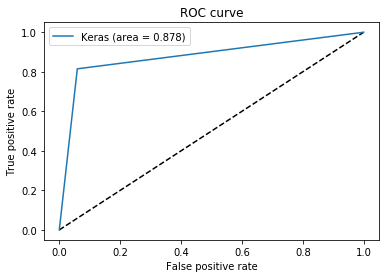

In [50]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

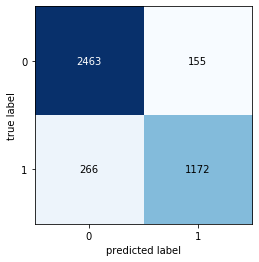

In [2]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary1 = np.array([[2463, 155],
                   [266, 1172]])
fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.show()

### Observation:
The model predicts high number of true positive and true negative samples, resulting in High precision and high recall.
Because of High precision and High recall for class 1 and 0, which is ideal for a real world scenario as the model doesn't misclassify healthy patients and doesn’t wrongly leave out the cancer patients, this proves our ultimate judgment of chosing this model was justified .
The model also has a high AUC value which is a good sign as AUC is senstiive to class imbalances.

# Transfer Learning

Now we will explore how the data in “datalabelsextraData.csv” can improve the cell-typec lassification model and use it accordingly.

We will use the concept of **Transfer Learning**. Transfer Learning is if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world.

This means that we can take advanatge of our already trained model ( which in this case is VGG16 architecture model) which has learned features maps from earlier without having to start from scratch by training a large model on a large dataset. Hence, we are going to use our best model which is trained on a much larger dataset and perform transfer learning on that 

We will perform two techniques, **Feature Extraction with data augmentation and Fine tuning** for this task.

- **Feature Extraction** : Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

- **Fine Tuning** : Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers
http://faculty.neu.edu.cn/yury/AAI/Textbook/Deep%20Learning%20with%20Python.pdf

## Feature Extraction with Image Data Augmentation


In [397]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model_transfer_learning = tf.keras.Sequential()
model_transfer_learning.add(load_model)

model_transfer_learning.add(layers.Flatten())
model_transfer_learning.add(layers.Dense(512, activation='relu'))
model_transfer_learning.add(layers.Dense(4, activation='softmax'))

In [398]:
model_transfer_learning.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 2)                 4075426   
_________________________________________________________________
flatten_21 (Flatten)         (None, 2)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 2052      
Total params: 4,079,014
Trainable params: 4,079,014
Non-trainable params: 0
_________________________________________________________________


**Now we will freeze the convultional base. This is very important as freezing helps in preventing their weights from being updated during training. if this is not done then the representation that was previously learned by convultional base will be modified during training.**


In [399]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model_transfer_learning.trainable_weights))

This is the number of trainable weights before freezing the conv base: 36


In [400]:
load_model.trainable = False

In [401]:
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model_transfer_learning.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [402]:
path = "./Image_classification_data/" #adapt this path, when running locally
train_path = path + 'patch_images/'

df_transfer_learning = pd.DataFrame({'path': glob(os.path.join(train_path,'*.png'))}) # load the filenames
print(df_transfer_learning)

df_transfer_learning['InstanceID'] = df_transfer_learning.path.map(lambda x: int(x.split('/')[3].split(".")[0]))
print(df_transfer_learning.dtypes)
labels = pd.read_csv(path+"data_labels_mainData.csv") # read the provided labels
print(labels.dtypes)

df_transfer_learning = pd.merge(df_transfer_learning, labels, on='InstanceID', how='right')


df_transfer_learning.head(3)


                                                    path
0      ./Image_classification_data/patch_images/3975.png
1      ./Image_classification_data/patch_images/17843...
2      ./Image_classification_data/patch_images/21329...
3      ./Image_classification_data/patch_images/8820.png
4      ./Image_classification_data/patch_images/14392...
5      ./Image_classification_data/patch_images/9280.png
6       ./Image_classification_data/patch_images/348.png
7      ./Image_classification_data/patch_images/15932...
8      ./Image_classification_data/patch_images/12085...
9      ./Image_classification_data/patch_images/1804.png
10     ./Image_classification_data/patch_images/22146...
11     ./Image_classification_data/patch_images/10692...
12     ./Image_classification_data/patch_images/20751...
13     ./Image_classification_data/patch_images/11598...
14     ./Image_classification_data/patch_images/4968.png
15     ./Image_classification_data/patch_images/10686...
16     ./Image_classification_d

,path,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,./Image_classification_data/patch_images/3975.png,3975,42,3975.png,others,3,0
1,./Image_classification_data/patch_images/8820.png,8820,17,8820.png,epithelial,2,1
2,./Image_classification_data/patch_images/9280.png,9280,21,9280.png,epithelial,2,1


In [403]:
print(df_transfer_learning.shape[0])  # 
df_transfer_learning.isnull().values.any()



9896


False

In [404]:
df_transfer_learning['isCancerous'] = df_transfer_learning['isCancerous'].apply(str)
with pd.option_context('mode.chained_assignment', None):
    train_data_, test_data_transfer = train_test_split(df_transfer_learning, test_size=0.2, 
                                              shuffle=True,random_state=0)
    
with pd.option_context('mode.chained_assignment', None):
    train_data_transfer, val_data_transfer = train_test_split(train_data_, test_size=0.25, 
                                            shuffle=True,random_state=0)
    
print(train_data_transfer.shape[0], val_data_transfer.shape[0], test_data_transfer.shape[0])


5937 1979 1980


In [405]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [406]:
train_data_transfer['cellType'] = train_data_transfer['cellType'].astype('str')
val_data_transfer['cellType'] = val_data_transfer['cellType'].astype('str')
test_data_transfer['cellType'] =  test_data_transfer['cellType'].astype('str')

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [407]:
train_generator_transfer =train_datagen.flow_from_dataframe(
dataframe=train_data_transfer,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="cellType",
batch_size=20,
class_mode="categorical",
target_size=(27,27)
)

val_generator_transfer = test_datagen.flow_from_dataframe(
dataframe=val_data_transfer,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="cellType",
batch_size=20,
class_mode="categorical",
target_size=(27,27)
)



Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [408]:
train_data_transfer

,path,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
9607,./Image_classification_data/patch_images/13547...,13547,10,13547.png,epithelial,2,1
3482,./Image_classification_data/patch_images/9395.png,9395,21,9395.png,epithelial,2,1
3189,./Image_classification_data/patch_images/116.png,116,36,116.png,epithelial,2,1
131,./Image_classification_data/patch_images/22393...,22393,58,22393.png,others,3,0
7048,./Image_classification_data/patch_images/521.png,521,20,521.png,epithelial,2,1
8870,./Image_classification_data/patch_images/8542.png,8542,18,8542.png,epithelial,2,1
8237,./Image_classification_data/patch_images/752.png,752,48,752.png,others,3,0
9451,./Image_classification_data/patch_images/13787...,13787,54,13787.png,others,3,0
9263,./Image_classification_data/patch_images/10139...,10139,41,10139.png,epithelial,2,1
8269,./Image_classification_data/patch_images/13742...,13742,54,13742.png,others,3,0


In [411]:
model_transfer_learning.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [412]:
history_transfer = model_transfer_learning.fit_generator(
      train_generator_transfer,
      steps_per_epoch=100,
      epochs=100,
      validation_data=val_generator_transfer,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 6s 56ms/step - loss: 0.9272 - accuracy: 0.6040 - val_loss: 0.8820 - val_accuracy: 0.5880
Epoch 2/100
100/100 [==============================] - 5s 54ms/step - loss: 0.9608 - accuracy: 0.5785 - val_loss: 0.8942 - val_accuracy: 0.5820
Epoch 3/100
100/100 [==============================] - 5s 55ms/step - loss: 0.9547 - accuracy: 0.5940 - val_loss: 0.8579 - val_accuracy: 0.5800
Epoch 4/100
100/100 [==============================] - 5s 54ms/step - loss: 0.9491 - accuracy: 0.5970 - val_loss: 0.8857 - val_accuracy: 0.5790
Epoch 5/100
100/100 [==============================] - 6s 60ms/step - loss: 0.9398 - accuracy: 0.5905 - val_loss: 0.8921 - val_accuracy: 0.5660
Epoch 6/100
100/100 [==============================] - 6s 64ms/step - loss: 0.9734 - accuracy: 0.5759 - val_loss: 0.8899 - val_accuracy: 0.5920
Epoch 7/100
100/100 [==============================] - 6s 55ms/step - loss: 0.9529 - accuracy: 0.6034 - val_loss: 0.9273 - val_accuracy:

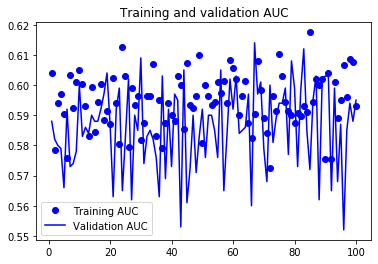

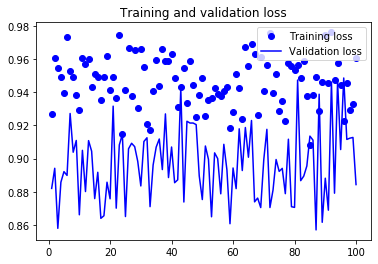

In [414]:
import matplotlib.pyplot as plt
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']
loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Observation:

We can see that the model is overfitting which means that the training dataset is performing too well compared to validation dataset. We will perform fine tuning and try to reduce this.

## Fine Tuning

In [415]:
load_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 128)        

fine-tuning slightly adjusts the more abstract representations of the model being reused, in order to make them more rele- vant for the problem at hand.

#### We will unfreeze the last convolutional layer.

##### Why?
- Earlier layers in the convolutional base encode more generic, reusable features, whereas layers higher up encode more specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem

In [416]:
load_model.trainable = True
set_trainable = False
for layer in load_model.layers:
    if layer.name == 'conv2d_32':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [417]:
load_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 128)        

In [418]:
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model_transfer_learning.trainable_weights))

This is the number of trainable weights after freezing the conv base: 16


In [419]:
model_transfer_learning.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [420]:
history_transfer_tune = model_transfer_learning.fit_generator(
      train_generator_transfer,
      steps_per_epoch=100,
      epochs=100,
      validation_data=val_generator_transfer,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 12s 116ms/step - loss: 0.9506 - accuracy: 0.5920 - val_loss: 1.0860 - val_accuracy: 0.4910
Epoch 2/100
100/100 [==============================] - 12s 118ms/step - loss: 0.9750 - accuracy: 0.5795 - val_loss: 0.8599 - val_accuracy: 0.6290
Epoch 3/100
100/100 [==============================] - 11s 111ms/step - loss: 0.9513 - accuracy: 0.5945 - val_loss: 0.8474 - val_accuracy: 0.6400
Epoch 4/100
100/100 [==============================] - 11s 113ms/step - loss: 0.8906 - accuracy: 0.6280 - val_loss: 0.8879 - val_accuracy: 0.6080
Epoch 5/100
100/100 [==============================] - 11s 113ms/step - loss: 0.9105 - accuracy: 0.5955 - val_loss: 0.8220 - val_accuracy: 0.6400
Epoch 6/100
100/100 [==============================] - 11s 109ms/step - loss: 0.9134 - accuracy: 0.6139 - val_loss: 0.8542 - val_accuracy: 0.6310
Epoch 7/100
100/100 [==============================] - 11s 106ms/step - loss: 0.9176 - accuracy: 0.6239 - val_loss: 0.8703 -

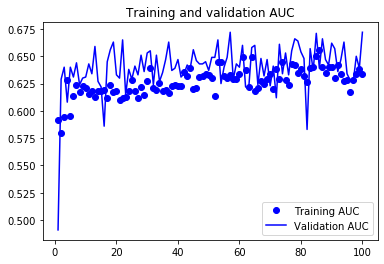

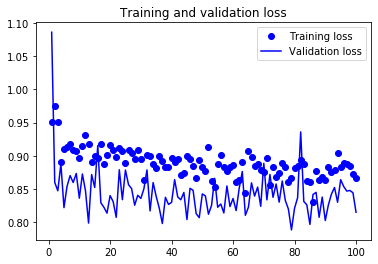

In [421]:
import matplotlib.pyplot as plt
acc = history_transfer_tune.history['accuracy']
val_acc = history_transfer_tune.history['val_accuracy']
loss = history_transfer_tune.history['loss']
val_loss = history_transfer_tune.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Note: It is a Training vs validation accuracy graph.

### Observation:

The model doesnt'seem to overfit as much but the performance has improved. We would need to build confusion matrix to see which class the model is not predicting correctly.

### Evaluation of our model

In [422]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_transfer =test_datagen.flow_from_dataframe(
dataframe=test_data_transfer,
directory="./Image_classification_data/patch_images",
x_col="ImageName",
y_col="cellType",
batch_size=1,
class_mode="categorical",
target_size=(27,27),
    shuffle= False
)

Found 1980 validated image filenames belonging to 4 classes.


In [423]:
model_transfer_learning.evaluate(test_generator_transfer)

1980/1980 [==============================] - 10s 5ms/step - loss: 0.8703 - accuracy: 0.6313


[0.8702552914619446, 0.631313145160675]

In [424]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}




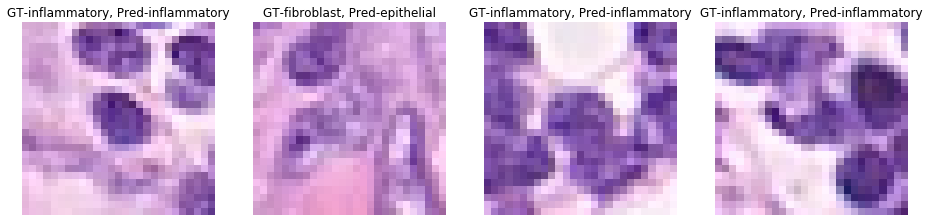

In [426]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,20))
batches = 0
for x,y in test_generator_transfer:
#         print(y)
        batches = batches + 1
        y_hat = model_transfer_learning.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [427]:
predict_transfer = model_transfer_learning.predict_generator(test_generator_transfer,steps = len(test_generator_transfer.filenames))



In [429]:
predicted_transfer = np.argmax(predict_transfer,axis=1)
true_classes_transfer = test_generator_transfer.classes


In [430]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(true_classes_transfer, predicted_transfer)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[ 71 213  95   0]
 [ 29 443  52   3]
 [  0  66 721   0]
 [ 67 164  41  15]]


In [428]:
predict_transfer

array([[0.33133715, 0.41514987, 0.00242735, 0.25108555],
       [0.22527465, 0.5519336 , 0.02515056, 0.19764118],
       [0.09580503, 0.05358967, 0.81270576, 0.03789961],
       ...,
       [0.23880723, 0.53056914, 0.06166176, 0.1689619 ],
       [0.22763354, 0.5507177 , 0.03498314, 0.18666568],
       [0.08750102, 0.04795209, 0.8290411 , 0.03550574]], dtype=float32)

### Observation:

Since the cell-type classifier is only trained on 9896 images and the Is-Cancerous classifier is trained on all 20,280 images, we will transfer the learning of our trained VGG16 model to improve cell-type classification. The spatial hierarchy of features learned by our pre-trained network on the entire dataset can act as a generic model. We used our pre-trained network in two different ways - feature extraction and fine tuning. We observed that our model performs significantly better at predicting epithelial with a recall of 0.91, but fails to accurately predict the other cell types. This is explained by the direct correlation between ‘IsCancerous’ and  ‘Epithelial’ cell-type. Transfer Learning benefits from similarity in problem domain, hence our pre-trained network is excellent at differentiating between cancerous and normal cells, but not at predicting the 3 cell-types that can all belong to normal cells.

